In [1]:
from typing_extensions import TypedDict, Annotated, List, Literal
from langchain_core.messages import AnyMessage, AIMessage, HumanMessage, SystemMessage
from langgraph.graph import add_messages
from typing import Dict, List, Optional, Union, Literal
from pydantic import BaseModel, Field
from IPython.display import Image, display 
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

# LLM Definition

In [2]:
from langchain_core.messages import HumanMessage

from dotenv import load_dotenv
load_dotenv()
import os 

os.environ['OPENAI_API_KEY'] = os.getenv("OPENAI_API_KEY")
os.environ['GROQ_API_KEY'] = os.getenv("GROQ_API_KEY")
os.environ['LANGSMITH_API_KEY'] = os.getenv("LANGSMITH_API_KEY")
os.environ['LANGSMITH_PROJECT'] = os.getenv("LANGSMITH_PROJECT")
os.environ['LANGSMITH_TRACING'] = os.getenv("LANGSMITH_TRACING")
os.environ['GOOGLE_API_KEY'] = os.getenv("GOOGLE_API_KEY")

In [3]:
from langchain_groq import ChatGroq 
from langchain_google_genai import ChatGoogleGenerativeAI
# llm = ChatGroq(model="deepseek-r1-distill-llama-70b")
# llm = ChatGroq(model="qwen-2.5-32b")

llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2
)

# States Definition

In [4]:
## documents
# class DocumentSection(BaseModel):
#     title: str = Field(description="The title of the section")
#     content: str = Field(description="The content of the section")
    
## security review
class SecurityReview(BaseModel):
    sec_id : str = Field(description="The id of the security review")
    review : str = Field(description="The review of the security review")
    file_path : str = Field(description="The file path of the security review")
    recommendation : str = Field(description="The recommendation of the security review")
    priority : Literal["high", "medium", "low"] = Field(description="The priority of the security review")
    
## test cases
class TestCase(BaseModel):
    test_id : str = Field(description="The id of the test case")
    description : str = Field(description="The description of the test case")
    steps : List[str] = Field(description="The steps of the test case")
    status : Literal["draft", "pass", "fail"] = Field(description="The status of the test case")

In [5]:
## Project Requirements
class ProjectRequirements(BaseModel):
    title: str = Field(description="The title of the project")
    description: str = Field(description="The description of the project")
    requirements : List[str] = Field(description="The requirements of the project")

In [6]:
## User story
class UserStory(BaseModel):
    story_id : str = Field(description="The id of the user story")
    title : str = Field(description="The title of the user story")
    description : str = Field(description="The description of the user story")
    acceptance_criteria : List[str] = Field(description="The acceptance criteria of the user story")

In [7]:
class SDLCState(BaseModel):
    project_requirements : ProjectRequirements
    revised_count : int = Field(default=0, description="The number of times the revised")
    # User story
    user_stories : List[UserStory] = []
    user_story_messages : Annotated[list, add_messages] = []
    user_story_status : Literal["pending", "in_progress", "pending_approval", "feedback", "approved"] = "pending"
    
    # functional documents
    functional_documents : str = Field(default='', description='The functional documents')
    functional_messages : Annotated[list, add_messages] = []
    functional_status: Literal["pending", "in_progress", "pending_approval", "feedback", "approved"] = "pending"
    
    # technical documents
    technical_documents : str = Field(default='', description='The technical documents')
    technical_messages : Annotated[list, add_messages] = []
    technical_status: Literal["pending", "in_progress", "pending_approval", "feedback", "approved"] = "pending"
    
    # frontend code
    frontend_code : str = Field(default='', description="The frontend code")
    frontend_messages: Annotated[list, add_messages] = []
    frontend_status: Literal["pending", "in_progress", "pending_approval", "feedback", "approved"] = "pending"
    
    # backend code
    backend_code : str = Field(default= '', description="The backend code")
    backend_messages: Annotated[list, add_messages] = []
    backend_status: Literal["pending", "in_progress", "pending_approval", "feedback", "approved"] = "pending"

    # security review
    security_reviews : List[SecurityReview] = []
    security_reviews_messages: Annotated[list, add_messages] = []
    security_reviews_status : Literal["pending", "in_progress", "pending_approval", "feedback", "approved"] = "pending"

    ## test cases
    test_cases : List[TestCase] = []
    test_cases_messages: Annotated[list, add_messages] = []
    test_cases_status : Literal["pending", "in_progress", "pending_approval", "feedback", "approved"] = "pending"

    ## qa testing
    qa_testing : List[TestCase] = []
    qa_testing_messages: Annotated[list, add_messages] = []
    qa_testing_status : Literal["pending", "in_progress", "pending_approval", "feedback", "approved"] = "pending"

    ## Code deployment
    deployment : str = Field(default='', description="The code deployment")
    deployment_messages: Annotated[list, add_messages] = []


# Node Helper functions with LLM call

## User Stories

In [8]:
project_title = "PayMate: Your Ultimate Payment Companion"
project_description = "PayMate is a comprehensive payment application that allows users to perform seamless transactions using the Unified Payments Interface (UPI). Beyond basic payments, PayMate offers features such as quick loans, bill payments, and a user-friendly interface, making it a one-stop solution for all financial needs."
requirements = ["Implement multi-factor authentication, including biometrics (fingerprint and facial recognition) and MPIN, to secure user accounts.​", "Enable users to link multiple bank accounts and perform instant fund transfers using UPI.", "Provide users with access to instant micro-loans with minimal documentation.", "Allow users to pay utility bills such as electricity, water, gas, and broadband directly through the app."]
requirements_string = "\n".join(requirements)

In [9]:
generate_user_stories_system_prompt = """
**ROLE & OBJECTIVE**

You are an expert Agile Product Owner. Your task is to analyze structured project requirements and generate clear, actionable 4 to 6 user stories ready for development. Return the OUTPUT in the JSON format only. 

---

**TASK BREAKDOWN:**
1. **Analyze** project requirements, objectives, and user needs.
2. **Extract** core features and define user roles.
3. **Decompose** requirements into independent, testable user stories.
4. **Generate** user stories using:
   - **As a [user], I want [goal], so that [value].**
   - Clear, testable **acceptance criteria**.
5. **Prioritize** based on business impact and feasibility.

---

**DESIRED OUTPUT TEMPLATE IN LIST OF JSON**
```json
[
    {
        "story_id"="US-001",
        "title"="Manage Shopping Cart",
        "description"="As a shopper, I want to modify my cart before checkout.",
        "acceptance_criteria"=[
            "User can add/remove items.",
            "User can update item quantity.",
            "Cart updates reflect in real-time.",
            "User can see the total price of the cart."
        ]
    }
]
```

---

**GUIDELINES:**
✅ Align with project requirements.
✅ Use concise, clear language.
✅ Ensure user stories are independent and testable.
✅ Prioritize based on business impact.
✅ The **acceptance criteria must be between 2 to 4 points**—no more, no less.  
🚫 Avoid vagueness, missing criteria, or unnecessary technical details.
"""

In [10]:
revised_user_stories_system_prompt = """
# **ROLE & OBJECTIVE**  
You are an expert Agile Product Owner. Your task is to analyze the user stories based on user feedback and refine user stories with existing user stories and return the output in the JSON format only. 

---

TASK BREAKDOWN:  
1. Analyze `user_story` and `user_feedback`.  
2. Identify gaps and improve clarity.  
3. Ensure user stories follow:  
   - "As a [user], I want [goal], so that [value]."  
   - **2 to 4** clear, testable acceptance criteria.  

---

**DESIRED OUTPUT TEMPLATE IN LIST OF JSON**  
```json
[
    {  
        "story_id": "US-001",  
        "title": "Manage Shopping Cart",  
        "description": "As a shopper, I want to modify my cart before checkout, so that I can finalize my purchase conveniently.",  
        "acceptance_criteria": [  
            "User can add/remove items.",  
            "User can update item quantity.",  
            "Cart updates reflect in real-time.",  
            "User can see the total price of the cart."
        ]  
    }  
]  
```

---

GUIDELINES:  
✅ Ensure stories are clear, independent, and testable.  
✅ Incorporate feedback without losing business goals.  
✅ Acceptance criteria must be **2 to 4** points.  
🚫 Avoid unnecessary technical details or vague requirements.  
"""

In [11]:
from langchain_core.prompts import PromptTemplate 
from langchain_core.output_parsers import JsonOutputParser 
json_output_parser = JsonOutputParser()

json_prompt_template = PromptTemplate(
    template="{system_prompt} \n {format_instruction} \n {human_query} \n",
    input_variables= ["system_prompt", "human_query",],
    partial_variables={"format_instruction" : json_output_parser.get_format_instructions()}
)

In [12]:
def generate_user_stories_from_llm(project_title, project_description, requirements):
    user_query =  f"Create a user stories for the this project title: {project_title} and description: {project_description} and requirements: {requirements}"
    chain = json_prompt_template | llm | json_output_parser
    response = chain.invoke({"system_prompt" : generate_user_stories_system_prompt, "human_query" : user_query})
    return response

# user_stories = generate_user_stories_from_llm(project_title, project_description, requirements_string)
# user_stories

In [13]:
def revised_user_stories_from_llm(user_stories, user_feedback):
    user_query =  f"user_feedback: {user_feedback} and user_stories: {user_stories}"
    chain = json_prompt_template | llm | json_output_parser
    response = chain.invoke({"system_prompt" : revised_user_stories_system_prompt, "human_query" : user_query})
    return response

# user_feedback = "In above user stories, add a user story for buy insurance from the app and return all the user stories"
# revised_user_stories = revised_user_stories_from_llm(user_stories, user_feedback) 
# revised_user_stories

## Functional documents

### prompt

In [14]:
functional_document_system_prompt = """
YOU ARE A SENIOR BUSINESS ANALYST AND FUNCTIONAL DESIGN EXPERT WITH EXTENSIVE EXPERIENCE IN THE SOFTWARE DEVELOPMENT LIFE CYCLE (SDLC) AND A STRONG TRACK RECORD OF DELIVERING WORLD-CLASS FUNCTIONAL SPECIFICATION DOCUMENTS (FSD) FOR ENTERPRISE SOFTWARE PROJECTS. RETURN THE OUTPUT IN MARKDOWN FORMAT ONLY. 

YOUR TASK IS TO TRANSLATE PROVIDED USER STORIES INTO A **COMPREHENSIVE, PROFESSIONAL FUNCTIONAL SPECIFICATION DOCUMENT** FOR THE DESIGN PHASE. 

###INSTRUCTIONS###

- CONVERT GIVEN USER STORIES INTO A FORMAL FUNCTIONAL SPECIFICATION DOCUMENT (FSD)
- INCLUDE THE FOLLOWING SECTIONS:
   - **1. INTRODUCTION:** PURPOSE, PROJECT SCOPE, AND SYSTEM OVERVIEW
   - **2. BUSINESS CONTEXT:** PROJECT BACKGROUND, BUSINESS NEEDS, AND OBJECTIVES
   - **3. STAKEHOLDER ANALYSIS:** IDENTIFY PRIMARY STAKEHOLDERS AND USERS IMPACTED
   - **4. FUNCTIONAL REQUIREMENTS:** DETAILED REQUIREMENTS WITH UNIQUE IDENTIFIERS (FR-1, FR-2, etc.)
   - **5. USE CASES / WORKFLOWS:** UML DIAGRAMS OR TEXTUAL FLOWS (ACTIVITY/SEQUENCE DIAGRAMS PREFERRED)
   - **6. DATA REQUIREMENTS:** INPUT FIELDS, OUTPUT FIELDS, VALIDATION RULES, AND DATA FORMATS
   - **7. NON-FUNCTIONAL REQUIREMENTS (NFRs):** PERFORMANCE, SECURITY, SCALABILITY, USABILITY, LEGAL, ETC.
   - **8. DEPENDENCIES & ASSUMPTIONS:** INTERNAL, EXTERNAL, TECHNICAL, OR BUSINESS DEPENDENCIES
   - **9. EDGE CASES & EXCEPTION HANDLING:** POTENTIAL FAILURE POINTS, ALTERNATE FLOWS, AND LIMITATIONS
   - **10. ACCEPTANCE CRITERIA:** AGGREGATE ACCEPTANCE CRITERIA FROM USER STORIES IN A CHECKLIST FORMAT
   - **11. GLOSSARY & DEFINITIONS:** DEFINE ALL BUSINESS TERMS, ROLES, ACRONYMS, AND DOMAIN-SPECIFIC TERMINOLOGY
   - **OPTIONAL: TRACEABILITY MATRIX:** MAP USER STORIES TO THEIR CORRESPONDING FUNCTIONAL REQUIREMENTS

- ALIGN DOCUMENT TO BE USEFUL FOR BOTH **BUSINESS STAKEHOLDERS** AND **TECHNICAL TEAMS** INVOLVED IN THE DESIGN PHASE
- MAINTAIN A FORMAL, EXECUTIVE-READY TONE WITH CLEAR AND CONCISE LANGUAGE
- FOLLOW THE "CHAIN OF THOUGHTS" PROCESS METICULOUSLY BEFORE PRODUCING THE FINAL DOCUMENT
- WHERE APPROPRIATE, OFFER PROFESSIONAL RECOMMENDATIONS IF GAPS, RISKS, OR MISSING ASSUMPTIONS ARE IDENTIFIED
- THE FINAL OUTPUT SHOULD BE BETWEEN **1200 TO 1500 WORDS**.

###CHAIN OF THOUGHTS###

1. UNDERSTAND:
   1.1. DEEPLY ANALYZE THE USER STORIES TO UNCOVER SYSTEM OBJECTIVES, USER INTENTIONS, AND BUSINESS VALUE.
   1.2. DETERMINE THE PRIMARY AUDIENCE, THEIR PAIN POINTS, AND THE IMPACT THIS SYSTEM WILL HAVE ON THEIR WORKFLOW.

2. FRAME:
   2.1. DESIGN THE STRUCTURE OF THE DOCUMENT FOLLOWING INDUSTRY STANDARDS FOR FUNCTIONAL SPECIFICATIONS.
   2.2. LIST ALL STAKEHOLDER GROUPS WHO WILL RELY ON THIS DOCUMENT.

3. EXTRACT:
   3.1. TRANSLATE EACH USER STORY INTO PRECISE FUNCTIONAL REQUIREMENTS (FR) WITH TRACEABLE IDs.
   3.2. FOR EACH FR, INCLUDE THE TRIGGER, SYSTEM RESPONSE, USER ACTIONS, AND ASSOCIATED DATA ELEMENTS.

4. REFINE:
   4.1. VALIDATE THAT EACH REQUIREMENT CONTRIBUTES TO MEETING THE PROJECT OBJECTIVES.
   4.2. IDENTIFY ANY NON-FUNCTIONAL CONSTRAINTS THAT MAY AFFECT USER EXPERIENCE OR SYSTEM PERFORMANCE.

5. DETAIL:
   5.1. PROVIDE COMPLETE, WELL-ORGANIZED SECTIONS, INCLUDING DIAGRAMS, TABLES, OR LISTS WHERE USEFUL.
   5.2. ENSURE THAT EDGE CASES AND EXCEPTION HANDLING ARE FULLY COVERED.

6. ENHANCE:
   6.1. INCLUDE A GLOSSARY TO FACILITATE UNDERSTANDING ACROSS TECHNICAL AND NON-TECHNICAL STAKEHOLDERS.
   6.2. OFFER OPTIONAL TRACEABILITY MATRIX FOR GREATER ACCOUNTABILITY AND TRACKING.

7. FINAL ANSWER:
   7.1. OUTPUT A HIGH-QUALITY, BUSINESS-READY FUNCTIONAL SPECIFICATION DOCUMENT THAT IS FULLY TRACEABLE TO THE INPUT USER STORIES AND READY FOR HANDOVER TO DESIGN/DEVELOPMENT TEAMS.

###WHAT NOT TO DO###

DO NOT:
- CREATE GENERIC OR SUPERFICIAL REQUIREMENTS WITHOUT CONNECTION TO USER STORIES.
- OMIT ACCEPTANCE CRITERIA, EDGE CASES, OR NON-FUNCTIONAL REQUIREMENTS.
- MIX TECHNICAL (CODE-LEVEL) DETAILS OR ARCHITECTURE INTO THE DOCUMENT.
- USE INFORMAL OR OVERLY TECHNICAL JARGON THAT BUSINESS STAKEHOLDERS CANNOT EASILY UNDERSTAND.
- IGNORE TRACEABILITY BETWEEN USER STORIES, REQUIREMENTS, AND BUSINESS GOALS.

###FEW-SHOT EXAMPLES###

####USER STORY INPUT:
AS A **registered user**, I WANT **to reset my password via an email verification process**, SO THAT **I can regain access to my account securely if I forget my password**.

####DESIRED FUNCTIONAL SPECIFICATION OUTPUT:

**1. INTRODUCTION**  
This document defines the functional requirements for the Password Reset Feature of the User Management System.

**2. BUSINESS CONTEXT**  
The business needs a secure mechanism for users to recover access to their accounts without compromising security, improving customer satisfaction and retention.

**3. FUNCTIONAL REQUIREMENTS**  
FR-1: The system shall provide a "Forgot Password" option on the login page.  
FR-2: The system shall send a time-limited reset link to the user's registered email address.  
FR-3: The system shall validate new passwords against password policy rules.  
FR-4: The system shall notify users of successful password reset and redirect them to the login page.

**4. USE CASES/WORKFLOWS**  
[Insert basic UML Use Case Diagram or Textual Workflow]

**5. DATA REQUIREMENTS**  
- Email address input (validated for format)  
- Password input (min 8 characters, 1 special character, 1 number)  
- Token expiration timestamp

**6. NON-FUNCTIONAL REQUIREMENTS**  
- The reset link shall expire within 24 hours.  
- The system must handle over 1000 concurrent password reset requests per minute.

**7. DEPENDENCIES & ASSUMPTIONS**  
- Email server availability  
- Users must have a valid registered email

**8. EDGE CASES & EXCEPTION HANDLING**  
- If a reset token is expired, show an "Expired link" message and provide an option to request a new reset link.  
- If an unregistered email is provided, show a generic "If your email is valid, a reset link will be sent" message.

**9. ACCEPTANCE CRITERIA**  
[Port acceptance criteria directly from the user story]

**10. GLOSSARY & DEFINITIONS**  
- Token: A temporary, secure string used to validate password reset requests.
"""

In [15]:
revised_functional_document_system_prompt = """
YOU ARE A SENIOR BUSINESS ANALYST AND FUNCTIONAL DESIGN EXPERT WITH EXTENSIVE EXPERIENCE IN THE SOFTWARE DEVELOPMENT LIFE CYCLE (SDLC) AND A STRONG TRACK RECORD OF DELIVERING WORLD-CLASS FUNCTIONAL SPECIFICATION DOCUMENTS (FSD) FOR ENTERPRISE SOFTWARE PROJECTS. RETURN THE OUTPUT IN MARKDOWN FORMAT ONLY.

YOUR TASK IS TO REVISE THE FUNCTIONAL DOCUMENTATION BASED ON THE PROVIDED USER FEEDBACK AND THE EXISTING FUNCTIONAL DOCUMENT.

### INSTRUCTIONS ###

- REVISE THE FUNCTIONAL DOCUMENT TO INCORPORATE THE USER FEEDBACK IN A **CLEAR, CONCISE, AND PROFESSIONAL** FORMAT.
- THE REVISED DOCUMENT SHOULD INCLUDE THE FOLLOWING SECTIONS:
  - **1. INTRODUCTION:** PURPOSE, PROJECT SCOPE, AND SYSTEM OVERVIEW
  - **2. BUSINESS CONTEXT:** PROJECT BACKGROUND, BUSINESS NEEDS, AND OBJECTIVES
  - **3. STAKEHOLDER ANALYSIS:** IDENTIFY PRIMARY STAKEHOLDERS AND USERS IMPACTED
  - **4. FUNCTIONAL REQUIREMENTS:** DETAILED REQUIREMENTS WITH UNIQUE IDENTIFIERS (FR-1, FR-2, etc.)
  - **5. USE CASES / WORKFLOWS:** UML DIAGRAMS OR TEXTUAL FLOWS (ACTIVITY/SEQUENCE DIAGRAMS PREFERRED)
  - **6. DATA REQUIREMENTS:** INPUT FIELDS, OUTPUT FIELDS, VALIDATION RULES, AND DATA FORMATS
  - **7. NON-FUNCTIONAL REQUIREMENTS (NFRs):** PERFORMANCE, SECURITY, SCALABILITY, USABILITY, LEGAL, ETC.
  - **8. DEPENDENCIES & ASSUMPTIONS:** INTERNAL, EXTERNAL, TECHNICAL, OR BUSINESS DEPENDENCIES
  - **9. EDGE CASES & EXCEPTION HANDLING:** POTENTIAL FAILURE POINTS, ALTERNATE FLOWS, AND LIMITATIONS
  - **10. ACCEPTANCE CRITERIA:** AGGREGATE ACCEPTANCE CRITERIA FROM USER STORIES IN A CHECKLIST FORMAT
  - **11. GLOSSARY & DEFINITIONS:** DEFINE ALL BUSINESS TERMS, ROLES, ACRONYMS, AND DOMAIN-SPECIFIC TERMINOLOGY
  - **OPTIONAL: TRACEABILITY MATRIX:** MAP USER STORIES TO THEIR CORRESPONDING FUNCTIONAL REQUIREMENTS

- ALIGN THE DOCUMENT TO BE USEFUL FOR BOTH **BUSINESS STAKEHOLDERS** AND **TECHNICAL TEAMS** INVOLVED IN THE DESIGN PHASE
- MAINTAIN A FORMAL, EXECUTIVE-READY TONE WITH CLEAR AND CONCISE LANGUAGE
- FOLLOW THE "CHAIN OF THOUGHTS" PROCESS METICULOUSLY BEFORE PRODUCING THE FINAL DOCUMENT
- WHERE APPROPRIATE, OFFER PROFESSIONAL RECOMMENDATIONS IF GAPS, RISKS, OR MISSING ASSUMPTIONS ARE IDENTIFIED
- THE FINAL OUTPUT SHOULD BE BETWEEN **1200 TO 1500 WORDS**.

### CHAIN OF THOUGHTS ###

1. UNDERSTAND:
   1.1. REVIEW AND COMPREHEND THE EXISTING FUNCTIONAL DOCUMENT AND THE USER FEEDBACK PROVIDED.
   1.2. IDENTIFY CHANGES OR IMPROVEMENTS NEEDED BASED ON THE USER'S COMMENTS AND REQUIREMENTS.

2. FRAME:
   2.1. ORGANIZE THE DOCUMENT IN A LOGICAL, INDUSTRY STANDARD STRUCTURE.
   2.2. IDENTIFY ALL STAKEHOLDER GROUPS WHO WILL RELY ON THIS DOCUMENT AND ACCOUNT FOR THEIR NEEDS IN THE REVISED VERSION.

3. EXTRACT:
   3.1. IDENTIFY THE IMPACT OF THE FEEDBACK ON EACH FUNCTIONAL REQUIREMENT AND ADJUST AS NECESSARY.
   3.2. ENSURE ALL FUNCTIONAL REQUIREMENTS ARE CLEARLY DEFINED AND TRACEABLE TO THE USER STORIES.

4. REFINE:
   4.1. VALIDATE THAT THE REVISED REQUIREMENTS ARE ALIGNED WITH THE PROJECT OBJECTIVES AND USER NEEDS.
   4.2. REVIEW THE NON-FUNCTIONAL REQUIREMENTS TO ENSURE THAT THEY MEET PERFORMANCE AND USABILITY EXPECTATIONS.

5. DETAIL:
   5.1. UPDATE DIAGRAMS, TABLES, OR LISTS AS NECESSARY TO CLARIFY THE UPDATED REQUIREMENTS.
   5.2. ENSURE EDGE CASES AND EXCEPTION HANDLING ARE ADEQUATELY COVERED BASED ON THE FEEDBACK.

6. ENHANCE:
   6.1. INCLUDE A GLOSSARY TO HELP STAKEHOLDERS, BOTH TECHNICAL AND NON-TECHNICAL, UNDERSTAND THE TERMINOLOGY.
   6.2. CONSIDER INCLUDING A TRACEABILITY MATRIX FOR GREATER ACCOUNTABILITY AND TRACKING OF REQUIREMENTS.

7. FINAL ANSWER:
   7.1. OUTPUT A REVISED, HIGH-QUALITY FUNCTIONAL SPECIFICATION DOCUMENT THAT FULLY ADDRESSES USER FEEDBACK AND IS READY FOR HANDOVER TO DESIGN/DEVELOPMENT TEAMS.

### WHAT NOT TO DO ###

DO NOT:
- LEAVE REQUIREMENTS AMBIGUOUS OR NOT FULLY ADDRESSED BASED ON USER FEEDBACK.
- OMIT ACCEPTANCE CRITERIA, EDGE CASES, OR NON-FUNCTIONAL REQUIREMENTS IN THE REVISED DOCUMENT.
- INCLUDE CODE-LEVEL DETAILS OR ARCHITECTURE IN THE DOCUMENT UNLESS SPECIFICALLY REQUESTED.
- USE INFORMAL LANGUAGE OR OVERLY TECHNICAL JARGON THAT MAY BE DIFFICULT FOR BUSINESS STAKEHOLDERS TO UNDERSTAND.
- IGNORE TRACEABILITY BETWEEN USER STORIES, REQUIREMENTS, AND BUSINESS GOALS.
"""

In [16]:
technical_document_system_prompt = """
You are a Senior Solution Architect, Enterprise Technical Designer, and Technical Writer with deep expertise in software design, system integration, and cloud-native architectures. Your task is to translate user stories and functional specifications into detailed technical design documents (TDDs) that can be used by engineering and architecture teams during the SDLC. The output should be a comprehensive and highly structured document suitable for design and implementation.

Please provide the final document in Markdown format only.

### INSTRUCTIONS ###

- Create a technical design document based on industry best practices, including the following sections:
   1. **Introduction & Purpose:** Clarify the purpose, intended audience, and scope of this technical design.
   2. **Architecture Overview:** Provide high-level and low-level architecture diagrams with explanations of components and interactions.
   3. **Modules & Components Design:** Break down the system into logical modules, components, and services, detailing each.
   4. **Data Model & Schema Design:** Define the entity relationships, schema structure, constraints, and sample data formats.
   5. **API Design (If applicable):** Specify the API endpoints, methods, requests, responses, error handling, and payloads.
   6. **Sequence & Activity Diagrams:** Include UML sequence and activity diagrams that explain core system flows.
   7. **Security Design:** Detail the authentication, authorization, encryption, and compliance strategies (e.g., GDPR).
   8. **Performance & Scalability:** Provide load expectations, scalability strategies, and performance benchmarks.
   9. **Error Handling & Logging:** Outline error handling strategies, exception flow, and logging policies.
   10. **Deployment & Environment Details:** Describe CI/CD pipelines, environment configurations, and cloud infrastructure diagrams.
   11. **Assumptions & Technical Dependencies:** List key assumptions, third-party integrations, and dependencies.
   12. **Risks & Mitigation Strategies:** Identify technical risks and possible mitigation/contingency plans.
   13. **Appendix (If applicable):** Provide additional notes, references, or supplementary material.

- Align the document to functional requirements, user stories, and non-functional needs.
- Provide sufficient detail to ensure a development team can implement the solution without ambiguity.
- Follow the "Chain of Thoughts" methodology before writing the document.
- THE FINAL OUTPUT SHOULD BE BETWEEN **1200 TO 1500 WORDS**.

### CHAIN OF THOUGHTS ###

1. **Contextualize:**
   - Deeply understand user stories, business context, and functional requirements.
   - Map out user roles, system goals, and key interactions.

2. **Outline:**
   - Organize the document based on standard TDD structure.
   - Identify core services, modules, infrastructure requirements, and API contracts.

3. **Translate:**
   - Convert functional requirements into technical module designs and API specifications.
   - Provide architecture diagrams, data flows, and system interaction diagrams.

4. **Validate:**
   - Verify alignment with non-functional requirements such as security, performance, and compliance.
   - Document edge cases, failure scenarios, and operational considerations.

5. **Produce:**
   - Write the document in a professional, technical tone.
   - Use clear language and appropriate diagrams/graphics where needed.

6. **Final Answer:**
   - Present the final technical design document in markdown format.

### WHAT NOT TO DO ###

STRICTLY AVOID:
- Writing generic, high-level documents without technical detail.
- Omitting security, performance, or deployment considerations.
- Leaving ambiguity in functional requirements or user stories.
- Including low-level implementation code or business cases (stick to design).
- Using informal language or non-standard formatting.

### FEW-SHOT EXAMPLES ###

#### USER STORY INPUT:
As a **registered user**, I want **to reset my password via an email verification process**, so that **I can regain access to my account securely if I forget my password**.

#### DESIRED TECHNICAL DESIGN OUTPUT:

**1. INTRODUCTION & PURPOSE**  
This document outlines the technical design for the Password Reset functionality as defined in the Functional Specification Document (FSD). This functionality enables users to securely reset their passwords via email verification.

**2. ARCHITECTURE OVERVIEW**  
[Insert Diagram: AWS Lambda, API Gateway, RDS, SES]  
The architecture utilizes a serverless design, with AWS Lambda managing backend logic, AWS SES handling email delivery, and RDS for persistent storage.

**3. MODULES & COMPONENTS DESIGN**  
- **Auth API Module:** Exposes RESTful endpoints for password reset request and confirmation.
- **Token Service Module:** Handles token generation, validation, and expiry management.
- **Notification Service:** Sends password reset emails using AWS SES.
- **Audit Logging Module:** Captures user reset activities for auditing and compliance.

**4. DATA MODEL & SCHEMA DESIGN**  
- **User Table:**  
  - `id` (UUID), `email` (string), `password_hash` (string), `reset_token_hash` (string), `reset_token_expiry` (datetime)  
- **Audit Log Table:**  
  - `log_id`, `user_id`, `action`, `timestamp`, `status`

**5. API DESIGN**  
- **POST /api/v1/auth/reset-request**  
  - Request: `{ "email": "user@example.com" }`  
  - Response: `202 Accepted`  
- **POST /api/v1/auth/reset-confirm**  
  - Request: `{ "token": "securetoken", "new_password": "StrongPass#2024" }`  
  - Response: `200 OK`

**6. SEQUENCE & ACTIVITY DIAGRAMS**  
[Insert Sequence Diagram: User -> API -> Token Service -> SES -> User]

**7. SECURITY DESIGN**  
- Enforce HTTPS for all communications.
- Encrypt reset tokens with SHA-256 and store them with an expiration time.
- Implement rate limiting and CSRF protection on API endpoints.

**8. PERFORMANCE & SCALABILITY**  
- System designed to handle up to 2,000 requests per minute.
- Ensure response time does not exceed 150ms for token validation.

**9. ERROR HANDLING & LOGGING**  
- Log failed token validation attempts with WARN level.
- Categorize errors (validation errors, expired tokens, server errors).

**10. DEPLOYMENT & ENVIRONMENT DETAILS**  
- Deploy using AWS Lambda, API Gateway, SES, and RDS.
- CI/CD implemented via AWS CodePipeline and Terraform for infrastructure-as-code.

**11. ASSUMPTIONS & TECHNICAL DEPENDENCIES**  
- Dependent on AWS SES for email delivery.
- External SMTP service may be used as a fallback.

**12. RISKS & MITIGATION STRATEGIES**  
- Risk: Delays in email delivery from SES.
- Mitigation: Use AWS SQS to implement a retry mechanism for failed email deliveries.
"""

In [17]:
revised_technical_document_system_prompt = """
You are a Senior Solution Architect, Enterprise Technical Designer, and Technical Writer with deep expertise in software design, system integration, and cloud-native architectures. Your task is to revise the existing technical documentation by following the user feedback, improving clarity, accuracy, and depth, and producing a comprehensive and structured document. The revised technical documentation should be suitable for engineers and architects to use during the SDLC, with a focus on detail and correctness.

Please provide the final document in Markdown format only.

### INSTRUCTIONS ###

- **Understand the User Feedback:** Review the user-provided feedback and incorporate necessary improvements into the existing technical document.
- **Enhance Clarity & Structure:** Ensure that the document is clear, precise, and logically organized. The final output should have an intuitive flow of information for both technical and non-technical stakeholders.
- **Maintain Technical Precision:** Ensure the technical details remain accurate and aligned with best practices. Add missing details where necessary, and revise any inaccuracies or ambiguities.
- **Follow a Standard Technical Documentation Format:** The document should follow industry best practices and cover key sections, such as:
   1. **Introduction & Purpose:** Clarify the purpose, intended audience, and scope of the document.
   2. **Architecture Overview:** Provide high-level and low-level architecture diagrams and descriptions of components and interactions.
   3. **Modules & Components Design:** Describe the system’s modules, components, and services in detail.
   4. **Data Model & Schema Design:** Define the relationships between entities, schema structure, constraints, and data formats.
   5. **API Design (if applicable):** Outline the API endpoints, methods, request/response formats, error handling, and payloads.
   6. **Sequence & Activity Diagrams:** Include appropriate UML diagrams explaining system interactions and flows.
   7. **Security Design:** Describe authentication, authorization, encryption, and compliance strategies.
   8. **Performance & Scalability:** Detail expected performance metrics, scalability strategies, and load handling.
   9. **Error Handling & Logging:** Explain how errors will be managed, logged, and tracked.
   10. **Deployment & Environment Details:** Detail CI/CD pipeline, environment configurations, and infrastructure requirements.
   11. **Assumptions & Dependencies:** List any key assumptions, third-party integrations, and technical dependencies.
   12. **Risks & Mitigation Strategies:** Identify any technical risks and strategies to mitigate or resolve them.
   13. **Appendix (if applicable):** Include any additional notes, references, or supporting material.

- **Focus on Providing Specific Solutions:** Address any specific issues highlighted in the feedback, including details on missing functionality, clarifications, or improvements.
- **Ensure Technical Depth and Precision:** Provide sufficient detail to ensure clarity and prevent ambiguity in design decisions, avoiding vague statements.
- **Follow the "Chain of Thoughts" Methodology:** Before revising, ensure that the document follows a well-thought-out structure and that the revision process is iterative, ensuring all technical and functional requirements are met.
- THE FINAL OUTPUT SHOULD BE BETWEEN **1200 TO 1500 WORDS**.

### CHAIN OF THOUGHTS ###

1. **Contextualize:**
   - Understand the user feedback fully and integrate any necessary revisions into the document.
   - Ensure you have a clear grasp of the system goals, user stories, and requirements before proceeding.
   
2. **Outline:**
   - Create an outline that organizes the document based on the revised technical design, incorporating feedback.
   - Ensure the sections are logically ordered and address all necessary components in depth.

3. **Revise:**
   - Modify existing content where the user feedback has pointed out weaknesses or missing information.
   - Incorporate additional details where required to clarify ambiguities or enhance the design.

4. **Validate:**
   - Cross-reference the revised design with functional and non-functional requirements, including security, performance, and compliance needs.
   - Make sure to capture any edge cases, failure scenarios, or exceptions pointed out in the feedback.

5. **Produce:**
   - Write the final document, ensuring it is technical, professional, and clear.
   - Use proper formatting, diagrams, and structured content where necessary to enhance the document's quality.

6. **Final Answer:**
   - Present the final revised technical design document in Markdown format.

### WHAT NOT TO DO ###

STRICTLY AVOID:
- Providing a high-level overview without addressing the technical details that the user feedback emphasizes.
- Ignoring any missing or unclear requirements from the feedback.
- Omitting key considerations like security, scalability, or performance that were highlighted.
- Including implementation-level code or business logic; stick strictly to the design aspects.
- Using informal language or non-standard formatting.

### EXAMPLE USER STORY WITH FEEDBACK ###

#### USER STORY INPUT:
As a **registered user**, I want **to reset my password via an email verification process**, so that **I can regain access to my account securely if I forget my password**.

#### USER FEEDBACK:
- The system needs to ensure that users can request a password reset multiple times without any risk of account lockout.
- The token expiry time should be adjustable based on system configuration.
- Include a user interface flow description for the password reset request.

#### DESIRED TECHNICAL DESIGN OUTPUT (After Incorporating Feedback):

**1. INTRODUCTION & PURPOSE**  
This document outlines the technical design for the Password Reset functionality, which allows users to securely reset their passwords through an email verification process. It provides clear steps for requesting and confirming password resets, as well as details on the system architecture and security design.

**2. ARCHITECTURE OVERVIEW**  
[Insert Diagram: AWS Lambda, API Gateway, RDS, SES]  
The system uses a serverless architecture, where AWS Lambda manages the backend logic, AWS SES is used for sending emails, and RDS stores user and token data. The design ensures scalability and security, with clear separation of concerns across modules.

**3. MODULES & COMPONENTS DESIGN**  
- **Auth API Module:** Manages password reset requests and confirmations. Ensures that multiple reset requests can be made without locking out users, by tracking requests and token expiries.
- **Token Service Module:** Generates, validates, and tracks tokens. The token expiry time is configurable via system settings.
- **Notification Service:** Sends email notifications through AWS SES with a password reset link.
- **UI Flow:** Describes the process for users to initiate a reset, including steps to enter an email, receive a reset link, and confirm the new password.

**4. DATA MODEL & SCHEMA DESIGN**  
- **User Table:**  
  - `id` (UUID), `email` (string), `password_hash` (string), `reset_token_hash` (string), `reset_token_expiry` (datetime)  
- **Audit Log Table:**  
  - `log_id`, `user_id`, `action`, `timestamp`, `status`

**5. API DESIGN**  
- **POST /api/v1/auth/reset-request**  
  - Request: `{ "email": "user@example.com" }`  
  - Response: `202 Accepted`
- **POST /api/v1/auth/reset-confirm**  
  - Request: `{ "token": "securetoken", "new_password": "StrongPass#2024" }`  
  - Response: `200 OK`

**6. SEQUENCE & ACTIVITY DIAGRAMS**  
[Insert Sequence Diagram: User -> API -> Token Service -> SES -> User]

**7. SECURITY DESIGN**  
- Ensure HTTPS for all API requests.
- Tokens are encrypted using SHA-256 and are stored with a configurable expiration time.
- Rate limiting and CAPTCHA are implemented to prevent abuse of the reset mechanism.

**8. PERFORMANCE & SCALABILITY**  
- The system is designed to handle up to 3,000 password reset requests per minute, with a response time of no more than 200ms.

**9. ERROR HANDLING & LOGGING**  
- Log failed attempts to reset the password with a timestamp and error code.
- Implement retry logic for failed email notifications.

**10. DEPLOYMENT & ENVIRONMENT DETAILS**  
- Deployed via AWS Lambda, API Gateway, SES, and RDS.
- CI/CD pipeline set up through AWS CodePipeline with Terraform for infrastructure management.

**11. ASSUMPTIONS & DEPENDENCIES**  
- External SMTP services are used as a backup for email delivery in case AWS SES fails.

**12. RISKS & MITIGATION STRATEGIES**  
- Risk: Token validation failure due to incorrect configurations.
- Mitigation: Provide clear logging and debugging tools for administrators.

"""

### documentations helper functions

In [18]:
llm = ChatGroq(model="qwen-2.5-32b")

prompt_template = PromptTemplate(
    template="{system_prompt} \n \n {human_query} \n",
    input_variables= ["system_prompt", "human_query",],
)

def generate_functional_document_from_llm(user_stories):
    user_query =  f"Create a functional documents for the user stories: {user_stories}."
    chain = prompt_template | llm 
    response = chain.invoke({"system_prompt" : functional_document_system_prompt, "human_query" : user_query})
    return response.content

user_feedback = "The user wants to reset their password via an email verification process."
def revised_functional_document_from_llm(functional_document, user_feedback):
    user_query =  f"Revise the functional document : {functional_document} and by following the user feedback: {user_feedback}. and return the complete revised functional document. "
    chain = prompt_template | llm 
    response = chain.invoke({"system_prompt" : revised_functional_document_system_prompt, "human_query" : user_query})
    return response.content

def generate_technical_document_from_llm(functional_document, user_stories):
    user_query =  f"Create technical documents for the user stories: {user_stories} and the functional document: {functional_document}"
    chain = prompt_template | llm 
    response = chain.invoke({"system_prompt" : technical_document_system_prompt, "human_query" : user_query})
    return response.content

def revised_technical_document_from_llm(technical_document, user_feedback):
    user_query =  f"Revise the technical document: {technical_document} and by following the user feedback: {user_feedback}."
    chain = prompt_template | llm 
    response = chain.invoke({"system_prompt" : revised_technical_document_system_prompt, "human_query" : user_query})
    return response.content

In [19]:
# def generate_functional_documents_from_llm(user_stories, project_requirements):
#     document = DocumentSection(
#         title = f"FUNCTIONAL REQUIREMENTS",
#         content = "FR-1: The system shall provide a Forgot Password option on the login page.")
#     functional_documents = [document]
#     return functional_documents


# def revised_functional_documents_from_llm(docs, user_feedback):
#     document = DocumentSection(
#         title = f"Revised FUNCTIONAL REQUIREMENTS",
#         content = "FR-1: The system shall provide a Forgot Password option on the login page.")
#     functional_documents = [document]
#     return functional_documents

# def generate_technical_documents_from_llm(user_stories, project_requirements):
#     sections=[
#         DocumentSection(
#             title="Technical Document: MODULES & COMPONENTS DESIGN",
#             content="Auth API Module: Exposes RESTful endpoints for password"
#         )
#     ]
#     return sections

# def revised_technical_documents_from_llm(docs, user_feedback):    
#     sections=[
#         DocumentSection(
#             title="Revised Technical Document: MODULES & COMPONENTS DESIGN",
#             content="Auth API Module: Exposes RESTful endpoints for password"
#         )
#     ]
#     return sections

## Frontend code 

In [20]:
def generate_frontend_code_from_llm(project_requirements, user_stories):
    frontend_code = "console.log('frontend code')"
    return frontend_code 

def revised_frontend_code_from_llm(code, user_feedback):
    frontend_code = "console.log('Revised frontend code')"
    return frontend_code


## Backend code

In [21]:
def generate_backend_code_from_llm(project_requirements, user_stories):
    backend_code = "print('backend code')"
    return backend_code 

def revised_backend_code_from_llm(code, user_feedback):
    backend_code = "print('Revised backend code')"
    return backend_code

## Security Review

In [22]:
security_reviews_system_prompt = """
YOU ARE AN ELITE SECURITY ANALYST TASKED WITH CONDUCTING A THOROUGH AND COMPREHENSIVE SECURITY REVIEW ON A PROVIDED CODEBASE.

FOR EACH SECURITY ISSUE FOUND, RETURN A STRUCTURED JSON OBJECT IN THE FOLLOWING FORMAT:
{
  "sec_id": "SR-001",
  "review": "DETAILED ANALYSIS OF THE SECURITY ISSUE FOUND WITHIN THE CODE, EXPLAINING THE ROOT CAUSE AND EXPLOIT SCENARIO",
  "file_path": "RELATIVE/PATH/TO/FILE.EXT",
  "recommendation": "SPECIFIC, TECHNICALLY FEASIBLE ACTION TO REMEDIATE THE DEFECT",
  "priority": "high"  # MUST BE ONE OF: "high", "medium", "low"
}

CHAIN OF THOUGHTS FOR SECURITY ANALYSIS:

1. UNDERSTAND THE CODEBASE:
   - READ THROUGH THE CODEBASE COMPLETELY TO UNDERSTAND ITS PURPOSE, ARCHITECTURE, AND THE DATA FLOW BETWEEN MODULES (E.G., AUTHENTICATION, API ROUTES, DATABASE INTERACTIONS).
   - IDENTIFY BUSINESS LOGIC AND SECURITY-CRITICAL PROCESSES.

2. IDENTIFY SECURITY PRINCIPLES:
   - REVIEW FOR ADHERENCE TO CORE SECURITY PRINCIPLES SUCH AS:
     - AUTHENTICATION AND AUTHORIZATION.
     - DATA VALIDATION (INPUT/OUTPUT).
     - ERROR HANDLING (SENSITIVE DATA EXPOSURE).
     - CRYPTOGRAPHY (PASSWORD HASHING, JWT SIGNING).
     - ACCESS CONTROL (USER ROLES AND PERMISSIONS).
     - DATABASE SECURITY (SQL INJECTION, DATA LEAKS).
     - SESSION MANAGEMENT (JWT EXPIRATION AND TOKEN LEAKAGE).

3. BREAKDOWN CODE INTO SECURITY-SENSITIVE SEGMENTS:
   - AUTHENTICATION ROUTES (E.G., USER LOGIN, REGISTRATION).
   - API ROUTES (PRODUCT MANAGEMENT, CART, ORDERS).
   - DATABASE INTERACTION (SQL QUERIES, SENSITIVE DATA STORAGE).
   - MIDDLEWARE (TOKEN VALIDATION, USER AUTHENTICATION).
   - EXTERNAL LIBRARIES (E.G., BCRYPTJS, JSONWEBTOKEN, EXPRESS-VALIDATOR).

4. ANALYZE FOR VULNERABILITIES:
   - SQL INJECTION: IDENTIFY WHETHER USER INPUT IS SAFELY HANDLED IN SQL QUERIES.
   - CROSS-SITE SCRIPTING (XSS): REVIEW IF USER INPUT IS SANITIZED BEFORE RENDERING OR LOGGING.
   - CROSS-SITE REQUEST FORGERY (CSRF): ENSURE API ACTIONS ARE PROTECTED AGAINST UNAUTHORIZED REQUESTS.
   - HARDCODED SECRETS: CHECK FOR HARDCODED PASSWORDS, SECRET KEYS, OR TOKENS.
   - INSECURE DATA STORAGE: REVIEW HOW SENSITIVE DATA (E.G., PASSWORDS) IS STORED AND TRANSMITTED.
   - IMPROPER ERROR HANDLING: MAKE SURE NO SENSITIVE INFORMATION IS EXPOSED IN ERROR MESSAGES OR STACK TRACES.

5. EDGE CASES AND LOW-PROBABILITY VULNERABILITIES:
   - REVIEW EDGE CASES SUCH AS TOKEN EXPIRATION HANDLING, RACE CONDITIONS, OR IMPROPER DATA VALIDATION, WHICH MIGHT NOT BE OBVIOUS BUT COULD STILL LEAD TO SERIOUS SECURITY ISSUES.

6. FINAL SECURITY REVIEW:
   - OUTPUT AN ARRAY OF JSON OBJECTS, EACH REPRESENTING A UNIQUE SECURITY DEFECT IDENTIFIED, ORDERED BY PRIORITY (FROM HIGH TO LOW).
   - THE REVIEW MUST BE DETAILED AND TECHNICAL, EXPLAINING THE ROOT CAUSE, IMPACT, AND RECOMMENDATIONS CLEARLY.
   - GENERATE AT LEAST 1 TO 3 SECURITY ISSUES IN EACH PRIORITY LEVEL ("high", "medium", and "low").

WHAT NOT TO DO:

- DO NOT RETURN RESULTS OUTSIDE THE JSON FORMAT.
- NEVER OMIT THE FOLLOWING FIELDS: "sec_id", "file_path", OR "priority".
- DO NOT PROVIDE VAGUE REVIEWS SUCH AS “NO ISSUES FOUND” WITHOUT A THOROUGH AND COMPLETE ANALYSIS.
- AVOID GENERIC OR REPETITIVE DESCRIPTIONS. EACH SECURITY ISSUE MUST BE UNIQUELY IDENTIFIED AND DETAILED.
- DO NOT RECOMMEND FIXES WITHOUT EXPLAINING WHY THEY ARE EFFECTIVE FOR REMEDIATING THE ISSUE.
- DO NOT USE PLACEHOLDER TEXT. REVIEWS MUST BE DIRECTLY BASED ON THE PROVIDED CODEBASE CONTEXT.
- NEVER IGNORE EDGE CASES OR POTENTIAL RISKS THAT MAY NOT BE OBVIOUS IN TYPICAL USE CASES BUT ARE STILL EXPLOITABLE.

EXAMPLE OUTPUT FORMAT:

[
  {
    "sec_id": "SR-001",
    "review": "User input is directly concatenated into an SQL query without sanitization, leading to SQL Injection vulnerability.",
    "file_path": "src/auth/login.js",
    "recommendation": "Use parameterized queries or ORM methods to safely process input.",
    "priority": "high"
  }
]
"""

In [23]:
backend_code = """
\n'I'll help you create a Node.js backend for an e-commerce application similar to Flipkart. We'll use Express.js for the API server and SQLite for the database since it doesn't require a separate server.\n\n<boltArtifact id=\"ecommerce-backend\" title=\"E-commerce Backend Application\">\n<boltAction type=\"file\" filePath=\"package.json\">\n{\n  \"name\": \"ecommerce-backend\",\n  \"version\": \"1.0.0\",\n  \"type\": \"module\",\n  \"scripts\": {\n    \"start\": \"node src/index.js\",\n    \"dev\": \"node --watch src/index.js\"\n  },\n  \"dependencies\": {\n    \"express\": \"^4.18.2\",\n    \"better-sqlite3\": \"^8.5.0\",\n    \"bcryptjs\": \"^2.4.3\",\n    \"jsonwebtoken\": \"^9.0.1\",\n    \"cors\": \"^2.8.5\",\n    \"express-validator\": \"^7.0.1\"\n  }\n}\n</boltAction>\n\n<boltAction type=\"file\" filePath=\"src/index.js\">\nimport express from 'express';\nimport cors from 'cors';\nimport { router as authRoutes } from './routes/auth.js';\nimport { router as productRoutes } from './routes/products.js';\nimport { router as cartRoutes } from './routes/cart.js';\nimport { router as orderRoutes } from './routes/orders.js';\nimport { initDb } from './db/init.js';\n\nconst app = express();\nconst PORT = 3000;\n\napp.use(cors());\napp.use(express.json());\n\n// Initialize database\ninitDb();\n\n// Routes\napp.use('/api/auth', authRoutes);\napp.use('/api/products', productRoutes);\napp.use('/api/cart', cartRoutes);\napp.use('/api/orders', orderRoutes);\n\napp.listen(PORT, () => {\n  console.log(`Server running on port ${PORT}`);\n});\n</boltAction>\n\n<boltAction type=\"file\" filePath=\"src/db/init.js\">\nimport Database from 'better-sqlite3';\n\nconst db = new Database('ecommerce.db');\n\nexport function initDb() {\n  // Users table\n  db.exec(`\n    CREATE TABLE IF NOT EXISTS users (\n      id INTEGER PRIMARY KEY AUTOINCREMENT,\n      email TEXT UNIQUE NOT NULL,\n      password TEXT NOT NULL,\n      name TEXT NOT NULL,\n      created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP\n    )\n  `);\n\n  // Products table\n  db.exec(`\n    CREATE TABLE IF NOT EXISTS products (\n      id INTEGER PRIMARY KEY AUTOINCREMENT,\n      name TEXT NOT NULL,\n      description TEXT,\n      price DECIMAL(10,2) NOT NULL,\n      stock INTEGER NOT NULL,\n      category TEXT NOT NULL,\n      image_url TEXT,\n      created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP\n    )\n  `);\n\n  // Cart table\n  db.exec(`\n    CREATE TABLE IF NOT EXISTS cart_items (\n      id INTEGER PRIMARY KEY AUTOINCREMENT,\n      user_id INTEGER NOT NULL,\n      product_id INTEGER NOT NULL,\n      quantity INTEGER NOT NULL,\n      FOREIGN KEY (user_id) REFERENCES users (id),\n      FOREIGN KEY (product_id) REFERENCES products (id)\n    )\n  `);\n\n  // Orders table\n  db.exec(`\n    CREATE TABLE IF NOT EXISTS orders (\n      id INTEGER PRIMARY KEY AUTOINCREMENT,\n      user_id INTEGER NOT NULL,\n      total_amount DECIMAL(10,2) NOT NULL,\n      status TEXT NOT NULL,\n      shipping_address TEXT NOT NULL,\n      created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP,\n      FOREIGN KEY (user_id) REFERENCES users (id)\n    )\n  `);\n\n  // Order items table\n  db.exec(`\n    CREATE TABLE IF NOT EXISTS order_items (\n      id INTEGER PRIMARY KEY AUTOINCREMENT,\n      order_id INTEGER NOT NULL,\n      product_id INTEGER NOT NULL,\n      quantity INTEGER NOT NULL,\n      price DECIMAL(10,2) NOT NULL,\n      FOREIGN KEY (order_id) REFERENCES orders (id),\n      FOREIGN KEY (product_id) REFERENCES products (id)\n    )\n  `);\n}\n\nexport default db;\n</boltAction>\n\n<boltAction type=\"file\" filePath=\"src/middleware/auth.js\">\nimport jwt from 'jsonwebtoken';\n\nconst JWT_SECRET = 'your-secret-key';\n\nexport function authenticateToken(req, res, next) {\n  const authHeader = req.headers['authorization'];\n  const token = authHeader && authHeader.split(' ')[1];\n\n  if (!token) {\n    return res.status(401).json({ error: 'Authentication required' });\n  }\n\n  jwt.verify(token, JWT_SECRET, (err, user) => {\n    if (err) {\n      return res.status(403).json({ error: 'Invalid token' });\n    }\n    req.user = user;\n    next();\n  });\n}\n\nexport function generateToken(user) {\n  return jwt.sign({ id: user.id, email: user.email }, JWT_SECRET, { expiresIn: '24h' });\n}\n</boltAction>\n\n<boltAction type=\"file\" filePath=\"src/routes/auth.js\">\nimport express from 'express';\nimport bcrypt from 'bcryptjs';\nimport { body, validationResult } from 'express-validator';\nimport db from '../db/init.js';\nimport { generateToken } from '../middleware/auth.js';\n\nexport const router = express.Router();\n\nrouter.post('/register',\n  [\n    body('email').isEmail(),\n    body('password').isLength({ min: 6 }),\n    body('name').notEmpty()\n  ],\n  async (req, res) => {\n    const errors = validationResult(req);\n    if (!errors.isEmpty()) {\n      return res.status(400).json({ errors: errors.array() });\n    }\n\n    const { email, password, name } = req.body;\n\n    try {\n      const hashedPassword = await bcrypt.hash(password, 10);\n      const stmt = db.prepare('INSERT INTO users (email, password, name) VALUES (?, ?, ?)');\n      const result = stmt.run(email, hashedPassword, name);\n      \n      const user = { id: result.lastInsertRowid, email, name };\n      const token = generateToken(user);\n      \n      res.status(201).json({ user, token });\n    } catch (error) {\n      res.status(500).json({ error: 'Error creating user' });\n    }\n  }\n);\n\nrouter.post('/login',\n  [\n    body('email').isEmail(),\n    body('password').notEmpty()\n  ],\n  async (req, res) => {\n    const { email, password } = req.body;\n\n    try {\n      const stmt = db.prepare('SELECT * FROM users WHERE email = ?');\n      const user = stmt.get(email);\n\n      if (!user || !(await bcrypt.compare(password, user.password))) {\n        return res.status(401).json({ error: 'Invalid credentials' });\n      }\n\n      const token = generateToken(user);\n      res.json({ user: { id: user.id, email: user.email, name: user.name }, token });\n    } catch (error) {\n      res.status(500).json({ error: 'Error during login' });\n    }\n  }\n);\n</boltAction>\n\n<boltAction type=\"file\" filePath=\"src/routes/products.js\">\nimport express from 'express';\nimport { body } from 'express-validator';\nimport db from '../db/init.js';\nimport { authenticateToken } from '../middleware/auth.js';\n\nexport const router = express.Router();\n\n// Get all products\nrouter.get('/', (req, res) => {\n  const stmt = db.prepare('SELECT * FROM products');\n  const products = stmt.all();\n  res.json(products);\n});\n\n// Get product by ID\nrouter.get('/:id', (req, res) => {\n  const stmt = db.prepare('SELECT * FROM products WHERE id = ?');\n  const product = stmt.get(req.params.id);\n  \n  if (!product) {\n    return res.status(404).json({ error: 'Product not found' });\n  }\n  \n  res.json(product);\n});\n\n// Add new product (admin only)\nrouter.post('/',\n  authenticateToken,\n  [\n    body('name').notEmpty(),\n    body('price').isFloat({ min: 0 }),\n    body('stock').isInt({ min: 0 }),\n    body('category').notEmpty()\n  ],\n  (req, res) => {\n    const { name, description, price, stock, category, image_url } = req.body;\n    \n    const stmt = db.prepare(`\n      INSERT INTO products (name, description, price, stock, category, image_url)\n      VALUES (?, ?, ?, ?, ?, ?)\n    `);\n    \n    const result = stmt.run(name, description, price, stock, category, image_url);\n    res.status(201).json({ id: result.lastInsertRowid, ...req.body });\n  }\n);\n</boltAction>\n\n<boltAction type=\"file\" filePath=\"src/routes/cart.js\">\nimport express from 'express';\nimport { body } from 'express-validator';\nimport db from '../db/init.js';\nimport { authenticateToken } from '../middleware/auth.js';\n\nexport const router = express.Router();\n\nrouter.use(authenticateToken);\n\n// Get cart items\nrouter.get('/', (req, res) => {\n  const stmt = db.prepare(`\n    SELECT ci.*, p.name, p.price, p.image_url\n    FROM cart_items ci\n    JOIN products p ON ci.product_id = p.id\n    WHERE ci.user_id = ?\n  `);\n  \n  const cartItems = stmt.all(req.user.id);\n  res.json(cartItems);\n});\n\n// Add to cart\nrouter.post('/',\n  [\n    body('product_id').isInt(),\n    body('quantity').isInt({ min: 1 })\n  ],\n  (req, res) => {\n    const { product_id, quantity } = req.body;\n    \n    const stmt = db.prepare(`\n      INSERT INTO cart_items (user_id, product_id, quantity)\n      VALUES (?, ?, ?)\n    `);\n    \n    const result = stmt.run(req.user.id, product_id, quantity);\n    res.status(201).json({ id: result.lastInsertRowid, ...req.body });\n  }\n);\n\n// Update cart item quantity\nrouter.put('/:id',\n  body('quantity').isInt({ min: 1 }),\n  (req, res) => {\n    const stmt = db.prepare(`\n      UPDATE cart_items\n      SET quantity = ?\n      WHERE id = ? AND user_id = ?\n    `);\n    \n    stmt.run(req.body.quantity, req.params.id, req.user.id);\n    res.json({ message: 'Cart updated' });\n  }\n);\n\n// Remove from cart\nrouter.delete('/:id', (req, res) => {\n  const stmt = db.prepare('DELETE FROM cart_items WHERE id = ? AND user_id = ?');\n  stmt.run(req.params.id, req.user.id);\n  res.json({ message: 'Item removed from cart' });\n});\n</boltAction>\n\n<boltAction type=\"file\" filePath=\"src/routes/orders.js\">\nimport express from 'express';\nimport { body } from 'express-validator';\nimport db from '../db/init.js';\nimport { authenticateToken } from '../middleware/auth.js';\n\nexport const router = express.Router();\n\nrouter.use(authenticateToken);\n\n// Get user orders\nrouter.get('/', (req, res) => {\n  const stmt = db.prepare(`\n    SELECT o.*, oi.product_id, oi.quantity, oi.price, p.name\n    FROM orders o\n    JOIN order_items oi ON o.id = oi.order_id\n    JOIN products p ON oi.product_id = p.id\n    WHERE o.user_id = ?\n  `);\n  \n  const orders = stmt.all(req.user.id);\n  res.json(orders);\n});\n\n// Create new order\nrouter.post('/',\n  [\n    body('shipping_address').notEmpty()\n  ],\n  (req, res) => {\n    const { shipping_address } = req.body;\n    \n    db.transaction(() => {\n      // Get cart items\n      const cartItems = db.prepare(`\n        SELECT ci.*, p.price\n        FROM cart_items ci\n        JOIN products p ON ci.product_id = p.id\n        WHERE ci.user_id = ?\n      `).all(req.user.id);\n      \n      if (cartItems.length === 0) {\n        return res.status(400).json({ error: 'Cart is empty' });\n      }\n      \n      // Calculate total\n      const totalAmount = cartItems.reduce((sum, item) => sum + (item.price * item.quantity), 0);\n      \n      // Create order\n      const orderStmt = db.prepare(`\n        INSERT INTO orders (user_id, total_amount, status, shipping_address)\n        VALUES (?, ?, ?, ?)\n      `);\n      \n      const orderResult = orderStmt.run(req.user.id, totalAmount, 'PENDING', shipping_address);\n      const orderId = orderResult.lastInsertRowid;\n      \n      // Create order items\n      const itemStmt = db.prepare(`\n        INSERT INTO order_items (order_id, product_id, quantity, price)\n        VALUES (?, ?, ?, ?)\n      `);\n      \n      cartItems.forEach(item => {\n        itemStmt.run(orderId, item.product_id, item.quantity, item.price);\n      });\n      \n      // Clear cart\n      db.prepare('DELETE FROM cart_items WHERE user_id = ?').run(req.user.id);\n      \n      res.status(201).json({\n        orderId,\n        totalAmount,\n        status: 'PENDING',\n        items: cartItems\n      });\n    })();\n  }\n);\n</boltAction>\n\n<boltAction type=\"shell\">\nnpm install && npm run dev\n</boltAction>\n\nThis sets up a complete e-commerce backend with:\n\n1. User authentication (register/login)\n2. Product management\n3. Shopping cart functionality\n4. Order processing\n5. SQLite database\n\nThe API endpoints are:\n\nAuthentication:\n- POST /api/auth/register\n- POST /api/auth/login\n\nProducts:\n- GET /api/products\n- GET /api/products/:id\n- POST /api/products\n\nCart:\n- GET /api/cart\n- POST /api/cart\n- PUT /api/cart/:id\n- DELETE /api/cart/:id\n\nOrders:\n- GET /api/orders\n- POST /api/orders\n\nYou can test the API endpoints using tools like Postman or curl.'\n\n"
"""

In [24]:
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature=0, max_tokens=None, timeout=None,  max_retries=2)

def generate_security_reviews_from_llm(backend_code):
    user_query =  f"Analyze this backend code: {backend_code} and create the security reviews for the code" 
    chain = json_prompt_template | llm  | json_output_parser
    response = chain.invoke({"system_prompt" : security_reviews_system_prompt, "human_query" : user_query})
    return response 

# response = generate_security_reviews_from_llm(backend_code)
# response

# Nodes Definition

### User stories

In [25]:
## User stories 
def process_project_requirements(state : SDLCState) -> SDLCState:
    print("In process_project_requirements...")
    return {
        "user_story_messages" : AIMessage(content="I've received your project requirements. I'll now generate user stories based on these requirements.")
    }
    
def generate_user_stories(state : SDLCState) -> SDLCState:
    print("In generate_user_stories...") 
    project_title = state.project_requirements.title
    project_description = state.project_requirements.description
    requirements = state.project_requirements.requirements
    user_stories = generate_user_stories_from_llm(project_title, project_description, requirements);
    
    return {
        "user_story_status" : 'pending_approval',
        "user_stories" : user_stories,
        "user_story_messages" : AIMessage(
            content = f"Based on your requirements, I've generated {len(user_stories)} user stories. Please review these user stories and provide feedback or type 'Approved' if you're satisfied."
        ),
        "revised_count" : 0
    }

def review_user_stories(state : SDLCState) -> SDLCState:
    print("In review_user_stories...")
    user_review = state.user_story_messages[-1].content
    user_review = user_review.lower().strip()
    print("user_review : ", user_review)  
    if user_review == "approved":
        return {
            "user_story_messages" : AIMessage(content="Great! Your user stories have been finalized. You can now proceed with your design process."),
            "user_story_status" : "approved",
        }
    else:
        return {
            "user_story_messages" :  AIMessage(content="I've received your feedback. I'll revise the user stories accordingly."),
            "user_story_status" : "feedback"
        }

def should_revise_user_stories(state : SDLCState) -> Literal["feedback", "approved"]:
    return "approved" if state.user_story_status == "approved" else "feedback"   

def revised_user_stories(state : SDLCState) -> SDLCState:
    print("In revised_user_stories...")
    user_review = state.user_story_messages[-2].content
    user_review = user_review.lower().strip()
    if state.user_story_status == 'feedback':
        revised_count = state.revised_count + 1
        print("revised_count : ", revised_count)
        if revised_count == 3:
            return {
                "user_story_messages" :  AIMessage(
                    content = f"User stories have been revision maxed out. Please review the user stories and continue with the next step."
                ),
                "user_story_status" : "approved"
            }
        user_stories = revised_user_stories_from_llm(state.user_stories, user_review)
        return {
                "user_stories" : user_stories,
                "user_story_messages" : AIMessage(
                    content = "I've revised the user stories based on your feedback.\n\nPlease review these updated user stories and provide additional feedback or type 'Approved' if you're satisfied."),
                "user_story_status" : "pending_approval",
                "revised_count" : revised_count
            }

### Functional documents

In [26]:
def create_functional_documents(state : SDLCState) -> SDLCState:
    print("In create_functional_documents...")
    doc_type = "functional"
    user_stories = state.user_stories
    documents = generate_functional_document_from_llm(user_stories)
    return {
        f"{doc_type}_documents": documents,
        f"{doc_type}_status": 'pending_approval',
        f"{doc_type}_messages": AIMessage(
            content=f"Please review {doc_type} design document and provide feedback or type 'Approved' if you're satisfied."
        ),
    }

def review_functional_documents(state : SDLCState) -> SDLCState:
    print("In review_functional_documents...")
    doc_type = "functional"
    user_feedback = state.functional_messages[-1].content.lower().strip()
    print("user feedback:", user_feedback)
    approved = (user_feedback == "approved")
    response = {
        f"{doc_type}_messages": AIMessage(
            content="Great! Your design documents have been finalized. You can now proceed with your design process."
            if approved else
            "I've received your feedback. I'll revise the design documents accordingly."
        ),
        f"{doc_type}_status": "approved" if approved else "feedback",
    }
    return response

def should_revise_function_documents(state : SDLCState) -> Literal["feedback", "approved"]:
    return "approved" if state.functional_status == "approved" else "feedback"  

def revise_functional_documents(state : SDLCState) -> SDLCState:
    print("In revise_functional_documents...")
    doc_type = "functional"
    user_feedback = state.functional_messages[-2].content.lower().strip()
    print("user feedback:", user_feedback)
    revised_count = state.revised_count + 1
    print("revised_count :", revised_count)

    if revised_count == 3:
        return {
            f"{doc_type}_messages": AIMessage(
                content="Design documents have been revision maxed out. Please review the these documents and continue with the next step."
            ),
            f"{doc_type}_status": "approved",
        }
        
    documents = revised_functional_document_from_llm(state.functional_documents, user_feedback)
    return {
        f"{doc_type}_documents": documents,
        f"{doc_type}_messages": AIMessage(
            content=f"Please review revised {doc_type} design documents and provide additional feedback or type 'Approved' if you're satisfied."
        ),
        f"{doc_type}_status": "pending_approval",
        "revised_count": revised_count
    }


### Technical documents

In [27]:
def create_technical_documents(state : SDLCState) -> SDLCState:
    print("In create_technical_documents...")
    doc_type = "technical"
    user_stories = state.user_stories
    functional_document = state.functional_documents
    documents = generate_technical_document_from_llm(functional_document, user_stories)
    return {
        f"{doc_type}_documents": documents,
        f"{doc_type}_status": 'pending_approval',
        f"{doc_type}_messages": AIMessage(
            content=f"Please review {doc_type} design document and provide feedback or type 'Approved' if you're satisfied."
        ),
    }

def review_technical_documents(state : SDLCState) -> SDLCState:
    print("In review_technical_documents...")
    doc_type = "technical"
    user_feedback = state.technical_messages[-1].content.lower().strip()
    print("user feedback:", user_feedback)
    approved = (user_feedback == "approved")
    response = {
        f"{doc_type}_messages": AIMessage(
            content="Great! Your design documents have been finalized. You can now proceed with your design process."
            if approved else
            "I've received your feedback. I'll revise the design documents accordingly."
        ),
        f"{doc_type}_status": "approved" if approved else "feedback",
    }
    return response

def should_revise_technical_documents(state : SDLCState) -> Literal["feedback", "approved"]:
    return "approved" if state.technical_status == "approved" else "feedback" 

def revise_technical_documents(state : SDLCState) -> SDLCState:
    print("In revise_technical_documents...")
    doc_type = "technical"
    user_feedback = state.technical_messages[-2].content.lower().strip()
    print("user feedback:", user_feedback)
    revised_count = state.revised_count + 1
    print("revised_count :", revised_count)

    if revised_count == 3:
        return {
            f"{doc_type}_messages": AIMessage(
                content="Design documents have been revision maxed out. Please review the these documents and continue with the next step."
            ),
            f"{doc_type}_status": "approved",
        }

    documents = revised_technical_document_from_llm(state.technical_documents, user_feedback)
    return {
        f"{doc_type}_documents": documents,
        f"{doc_type}_messages": AIMessage(
            content=f"Please review revised {doc_type} design documents and provide additional feedback or type 'Approved' if you're satisfied."
        ),
        f"{doc_type}_status": "pending_approval",
        "revised_count": revised_count
    }

## Frontend code

In [28]:
def generate_frontend_code_from_llm(project_requirements, user_stories):
    frontend_code = "console.log('frontend code')"
    return frontend_code 

def revised_frontend_code_from_llm(code, user_feedback):
    frontend_code = "console.log('Revised frontend code')"
    return frontend_code

In [29]:
def generate_frontend_code(state : SDLCState) -> SDLCState:
    print("In generate_frontend_code...")
    generate_code = generate_frontend_code_from_llm(state.project_requirements, state.user_stories)
    code_type = "frontend"

    return {
        f"{code_type}_code" : generate_code,
        f"{code_type}_status": 'pending_approval',
        f"{code_type}_messages": AIMessage(
            content=f"Please review {code_type} design document and provide feedback or type 'Approved' if you're satisfied."
        ),
    }

def review_frontend_code(state : SDLCState) -> SDLCState:
    print("In review_frontend_code")
    user_feedback = state.frontend_messages[-1].content.lower().strip()
    print("user feedback:", user_feedback)
    approved = user_feedback == "approved"
    code_type = "frontend"
    return {
        f"{code_type}_messages":AIMessage(
            content="Great! Code have been finalized. You can now proceed with next steps."
            if approved else
            "I've received your feedback. I'll revise the design documents accordingly."),
        f"{code_type}_status": "approved" if approved else "feedback"
    }

def should_fix_frontend_code(state : SDLCState) -> Literal["feedback", "approved"]:
    return "approved" if state.frontend_status == 'approved' else 'feedback'

def fix_frontend_code(state : SDLCState) -> SDLCState:
    print("In fix_frontend_code...")
    code_type = "frontend"
    user_feedback = state.frontend_messages[-2].content.lower().strip()
    revised_count = state.revised_count + 1
    print("revised_count :", revised_count)

    if revised_count == 3:
        return {
            f"{code_type}_messages": AIMessage(
                content="Code have been revision maxed out. Please review the code and continue with the next step."
            ),
            f"{code_type}_status": "approved"
        }
    
    revised_code = revised_frontend_code_from_llm(state.frontend_code, user_feedback)
    return {
        f"{code_type}_code": revised_code,
        f"{code_type}_messages": AIMessage(
            content=f"Please review revised {code_type} code and provide additional feedback or type 'Approved' if you're satisfied."
        ),
        f"{code_type}_status": "pending_approval",
        "revised_count": revised_count
    }

## Backend Code

In [30]:
def generate_backend_code_from_llm(project_requirements, user_stories):
    backend_code = "print('backend code')"
    return backend_code 

def revised_backend_code_from_llm(code, user_feedback):
    backend_code = "print('Revised backend code')"
    return backend_code

In [31]:
def generate_backend_code(state : SDLCState) -> SDLCState:
    print("In generate_backend_code...")
    generate_code = generate_backend_code_from_llm(state.project_requirements, state.user_stories)
    code_type = "backend"

    return {
        f"{code_type}_code" : generate_code,
        f"{code_type}_status": 'pending_approval',
        f"{code_type}_messages": AIMessage(
            content=f"Please review {code_type} design document and provide feedback or type 'Approved' if you're satisfied."
        ),
    }

def review_backend_code(state : SDLCState) -> SDLCState:
    print("In review_backend_code")
    user_feedback = state.backend_messages[-1].content.lower().strip()
    print("user feedback:", user_feedback)
    approved = user_feedback == "approved"
    code_type = "backend"
    return {
        f"{code_type}_messages":AIMessage(
            content="Great! Code have been finalized. You can now proceed with next steps."
            if approved else
            "I've received your feedback. I'll revise the design documents accordingly."),
        f"{code_type}_status": "approved" if approved else "feedback"
    }

def should_fix_backend_code(state : SDLCState) -> Literal["feedback", "approved"]:
    return "approved" if state.backend_status == 'approved' else 'feedback'

def fix_backend_code(state : SDLCState) -> SDLCState:
    print("In fix_backend_code...")
    code_type = "backend"
    user_feedback = state.backend_messages[-2].content.lower().strip()
    revised_count = state.revised_count + 1
    print("revised_count :", revised_count)

    if revised_count == 3:
        return {
            f"{code_type}_messages": AIMessage(
                content="Code have been revision maxed out. Please review the code and continue with the next step."
            ),
            f"{code_type}_status": "approved"
        }
    
    revised_code = revised_backend_code_from_llm(state.backend_code, user_feedback)
    return {
        f"{code_type}_code": revised_code,
        f"{code_type}_messages": AIMessage(
            content=f"Please review revised {code_type} code and provide additional feedback or type 'Approved' if you're satisfied."
        ),
        f"{code_type}_status": "pending_approval",
        "revised_count": revised_count
    }

## Security Review

In [32]:
def revised_backend_code_with_security_reviews_from_llm(code, reviews, user_feedback):
    backend_code = "print('Revised backend code with security reviews')"
    return backend_code

In [33]:
def generate_security_reviews(state : SDLCState) -> SDLCState:
    print("In generate_security_reviews...")
    security_reviews = generate_security_reviews_from_llm(backend_code)
    return {
        "security_reviews": security_reviews,
        "security_reviews_status": "pending_approval",
        "security_reviews_messages": AIMessage(
            content=f"Please review security reviews and provide feedback or type 'Approved' if you're satisfied."
        ),
    }

def security_review(state : SDLCState) -> SDLCState:
    print("In security_review...")
    user_feedback = state.security_reviews_messages[-1].content.lower().strip()
    print("user feedback:", user_feedback)
    approved = user_feedback == "approved"
    return {
        "security_reviews_status": "approved" if approved else "feedback",
        "security_reviews_messages": AIMessage(
            content="Great! Security reviews have been finalized. You can now proceed with next steps."
            if approved else
            "I've received your feedback. I'll revise the security reviews accordingly."),
    }

def should_fix_code_after_security_review(state : SDLCState) -> Literal["feedback", "approved"]:
    return "approved" if state.security_reviews_status == 'approved' else 'feedback'

def fix_code_after_security_review(state : SDLCState) -> SDLCState:
    print("In fix_code_after_security_review...")
    code_type = "backend"
    user_feedback = state.security_reviews_messages[-2].content.lower().strip()
    revised_count = state.revised_count + 1
    print("revised_count :", revised_count)

    if revised_count == 3:
        return {
            f"{code_type}_messages": AIMessage(
                content="Code have been revision maxed out. Please review the code and continue with the next step."
            ),
            f"{code_type}_status": "approved"
        }
    
    revised_code = revised_backend_code_with_security_reviews_from_llm(state.backend_code, state.security_reviews, user_feedback)
    return {
        f"{code_type}_code": revised_code,
        f"{code_type}_messages": AIMessage(
            content=f"Please review revised {code_type} code and provide additional feedback or type 'Approved' if you're satisfied."
        ),
        f"{code_type}_status": "pending_approval",
        "revised_count": revised_count
    }

## Test Cases

In [34]:
def generate_test_cases_from_llm(project_requirements, user_stories):
    test_cases = [
        TestCase(
        test_id="TC-001", 
        description="test_case_1", 
        steps=["step1", "step2", "step3"],
        status="pending")]
    return test_cases

def revised_test_cases_from_llm(test_cases, user_feedback):
    test_cases = [
        TestCase(
        test_id="TC-001", 
        description="Revised test_case_2", 
        steps=["step1", "step2", "step3"],
        status="pending")
    ]
    return test_cases


In [35]:
def write_test_cases(state : SDLCState) -> SDLCState: 
    print("In write_test_cases...")
    test_cases = generate_test_cases_from_llm(state.project_requirements, state.user_stories)
    return {
        "test_cases": test_cases,
        "test_cases_status": "pending_approval",
        "test_cases_messages": AIMessage(
            content=f"Please review test cases and provide feedback or type 'Approved' if you're satisfied."
        ),
    }


def test_cases_review(state : SDLCState) -> SDLCState:
    print("In test_cases_review...")
    user_feedback = state.test_cases_messages[-1].content.lower().strip()
    print("user feedback:", user_feedback)
    approved = user_feedback == "approved"
    return {
        "test_cases_status": "approved" if approved else "feedback",
        "test_cases_messages": AIMessage(
            content="Great! Test cases have been finalized. You can now proceed with next steps."
            if approved else
            "I've received your feedback. I'll revise the test cases accordingly."),
    }

def should_fix_test_cases(state : SDLCState) -> Literal["feedback", "approved"]:
    return "approved" if state.test_cases_status == 'approved' else 'feedback'

def fixed_testcases_after_review(state : SDLCState) -> SDLCState:
    print("In fixed_testcases_after_review...")
    user_feedback = state.test_cases_messages[-2].content.lower().strip()
    revised_count = state.revised_count + 1
    print("revised_count :", revised_count)

    if revised_count == 3:
        return {
            "test_cases_messages": AIMessage(
                content="Test cases have been revision maxed out. Please review the test cases and continue with the next step."
            ),
            "test_cases_status": "approved"
        }
    
    revised_test_cases = revised_test_cases_from_llm(state.test_cases, user_feedback)
    return {
        "test_cases": revised_test_cases,
        "test_cases_messages": AIMessage(
            content=f"Please review revised test cases and provide additional feedback or type 'Approved' if you're satisfied."
        ),
        "test_cases_status": "pending_approval",
        "revised_count": revised_count
    }

## QA testing

In [36]:
test_cases = [
        TestCase(
        test_id="TC-001", 
        description="test_case_1", 
        steps=["step1", "step2", "step3"],
        status="pass")]

In [37]:
def qa_testing_from_llm(test_cases):
    qa_testing = [
        TestCase(
            test_id="TC-001", 
            description="test_case_1", 
            steps=["step1", "step2", "step3"],
            status="pass"
        ),
    ]
    return qa_testing  # Returns a list of TestCase objects


def revised_backend_code_with_qa_testing_from_llm(code, failed_test_cases):
    backend_code = "print('Revised backend code with qa testing')"
    return backend_code

In [38]:
def perform_qa_testing(state : SDLCState) -> SDLCState:
    print("In perform_qa_testing...")
    test_cases = state.test_cases
    qa_testing = qa_testing_from_llm(test_cases)
    failed_test_cases = [test_case for test_case in qa_testing if test_case['status'] == "failed"]
    passed = len(failed_test_cases) == 0
    return {
        "qa_testing": qa_testing,
        "qa_testing_status": "passed" if passed else "failed",
        "qa_testing_messages": AIMessage(
            content="Great! QA testing have been finalized. You can now proceed with next steps."
            if passed else
            "I'll revise the code accordingly."),
    }

def should_fix_after_qa_testing(state : SDLCState) -> Literal["passed", "failed"]:
    return "passed" if state.qa_testing_status == 'passed' else 'failed'

def fixed_code_after_qa_testing(state : SDLCState) -> SDLCState:
    print("In fixed_code_after_qa_testing...")
    code_type = "backend"
    revised_count = state.revised_count + 1
    print("revised_count :", revised_count)

    if revised_count == 3:
        return {
            f"{code_type}_messages": AIMessage(
                content="Code have been revision maxed out. Please review the code and continue with the next step."
            ),
            f"{code_type}_status": "approved"
        }
    
    failed_test_cases = [test_case for test_case in state.qa_testing if test_case['status'] == "failed"]
    revised_code = revised_backend_code_with_qa_testing_from_llm(state.backend_code, failed_test_cases)
    return {
        f"{code_type}_code": revised_code,
        f"{code_type}_messages": AIMessage(
            content=f"Please review revised {code_type} code and provide additional feedback or type 'Approved' if you're satisfied."
        ),
        f"{code_type}_status": "pending_approval",
        "revised_count": revised_count
    }


## Code Deployment

In [39]:
def code_deployment(state : SDLCState) -> SDLCState:
    print("In code_deployment...")
    return {
        "deployment": "Code has been deployed successfully."
    }


# SDLC Workflow

In [40]:
## Node definition
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

sdlc_graph = StateGraph(SDLCState)

# Adding Nodes 
sdlc_graph.add_node("process_project_requirements", process_project_requirements)
sdlc_graph.add_node("generate_user_stories", generate_user_stories)
sdlc_graph.add_node("review_user_stories", review_user_stories)
sdlc_graph.add_node("revised_user_stories", revised_user_stories)

## Functional documents 
sdlc_graph.add_node("create_functional_documents", create_functional_documents)
sdlc_graph.add_node("review_functional_documents", review_functional_documents)
sdlc_graph.add_node("revise_functional_documents", revise_functional_documents)

## Technical documents 
sdlc_graph.add_node("create_technical_documents", create_technical_documents)
sdlc_graph.add_node("review_technical_documents", review_technical_documents)
sdlc_graph.add_node("revise_technical_documents", revise_technical_documents)

## Frontend code 
sdlc_graph.add_node("generate_frontend_code", generate_frontend_code)
sdlc_graph.add_node("review_frontend_code", review_frontend_code)
sdlc_graph.add_node("fix_frontend_code", fix_frontend_code)

## Backend code
sdlc_graph.add_node("generate_backend_code", generate_backend_code)
sdlc_graph.add_node("review_backend_code", review_backend_code)
sdlc_graph.add_node("fix_backend_code", fix_backend_code)

## Security Review
sdlc_graph.add_node("generate_security_reviews", generate_security_reviews)
sdlc_graph.add_node("security_review", security_review)
sdlc_graph.add_node("fix_code_after_security_review", fix_code_after_security_review)

## Test Cases
sdlc_graph.add_node("write_test_cases", write_test_cases)
sdlc_graph.add_node("test_cases_review", test_cases_review)
sdlc_graph.add_node("fixed_testcases_after_review", fixed_testcases_after_review)

## QA testing
sdlc_graph.add_node("perform_qa_testing", perform_qa_testing)
sdlc_graph.add_node("fixed_code_after_qa_testing", fixed_code_after_qa_testing)

## Code deployment
sdlc_graph.add_node("code_deployment", code_deployment)



## Edges
sdlc_graph.add_edge(START, "process_project_requirements")
sdlc_graph.add_edge("process_project_requirements", "generate_user_stories")
sdlc_graph.add_edge("generate_user_stories", "review_user_stories")
sdlc_graph.add_conditional_edges(
    "review_user_stories",
    should_revise_user_stories,
    {
        "feedback": "revised_user_stories",
        "approved": "create_functional_documents"
    }
)
sdlc_graph.add_edge("revised_user_stories", "review_user_stories")

## Design documents 
sdlc_graph.add_edge("create_functional_documents", "review_functional_documents")
sdlc_graph.add_conditional_edges(
    "review_functional_documents",
    should_revise_function_documents,
    {
        "feedback" : "revise_functional_documents",
        "approved" : "create_technical_documents"
    }
)
sdlc_graph.add_edge("revise_functional_documents", "review_functional_documents")
sdlc_graph.add_edge("create_technical_documents", "review_technical_documents")
sdlc_graph.add_conditional_edges(
    "review_technical_documents",
    should_revise_technical_documents,
    {
        "feedback" : "revise_technical_documents",
        "approved" : "generate_frontend_code"
    }
)
sdlc_graph.add_edge("revise_technical_documents", "review_technical_documents")

## Frontend code 
sdlc_graph.add_edge("generate_frontend_code", "review_frontend_code")
sdlc_graph.add_conditional_edges(
    "review_frontend_code",
    should_fix_frontend_code,
    {
        "feedback" : "fix_frontend_code",
        "approved" : "generate_backend_code"
    }
)
sdlc_graph.add_edge("fix_frontend_code", "review_frontend_code")

## Backend code 
sdlc_graph.add_edge("generate_backend_code", "review_backend_code")
sdlc_graph.add_conditional_edges(
    "review_backend_code",
    should_fix_backend_code,
    {
        "feedback" : "fix_backend_code",
        "approved" : "generate_security_reviews"
    }
)
sdlc_graph.add_edge("fix_backend_code", "review_backend_code")

## Security Review
sdlc_graph.add_edge("generate_security_reviews", "security_review")
sdlc_graph.add_conditional_edges(
    "security_review",
    should_fix_code_after_security_review,
    {
        "feedback" : "fix_code_after_security_review",
        "approved" : "write_test_cases"
    }
)

sdlc_graph.add_edge("fix_code_after_security_review", "review_backend_code")

## test cases
sdlc_graph.add_edge("write_test_cases", "test_cases_review")
sdlc_graph.add_conditional_edges(
    "test_cases_review",
    should_fix_test_cases,
    {
        "feedback" : "fixed_testcases_after_review",
        "approved" : "perform_qa_testing"
    }
)

sdlc_graph.add_edge("fixed_testcases_after_review", "test_cases_review")

## QA testing
sdlc_graph.add_conditional_edges(
    "perform_qa_testing",
    should_fix_after_qa_testing,
    {
        "failed" : "fixed_code_after_qa_testing",
        "passed" : "code_deployment"
    }
)

sdlc_graph.add_edge("fixed_code_after_qa_testing", "review_backend_code")

sdlc_graph.add_edge("code_deployment", END)

# Compile the graph
sdlc_workflow = sdlc_graph.compile(checkpointer=memory, interrupt_before=["review_user_stories", "review_functional_documents", "review_technical_documents", "review_frontend_code", "review_backend_code", "security_review", "test_cases_review"])

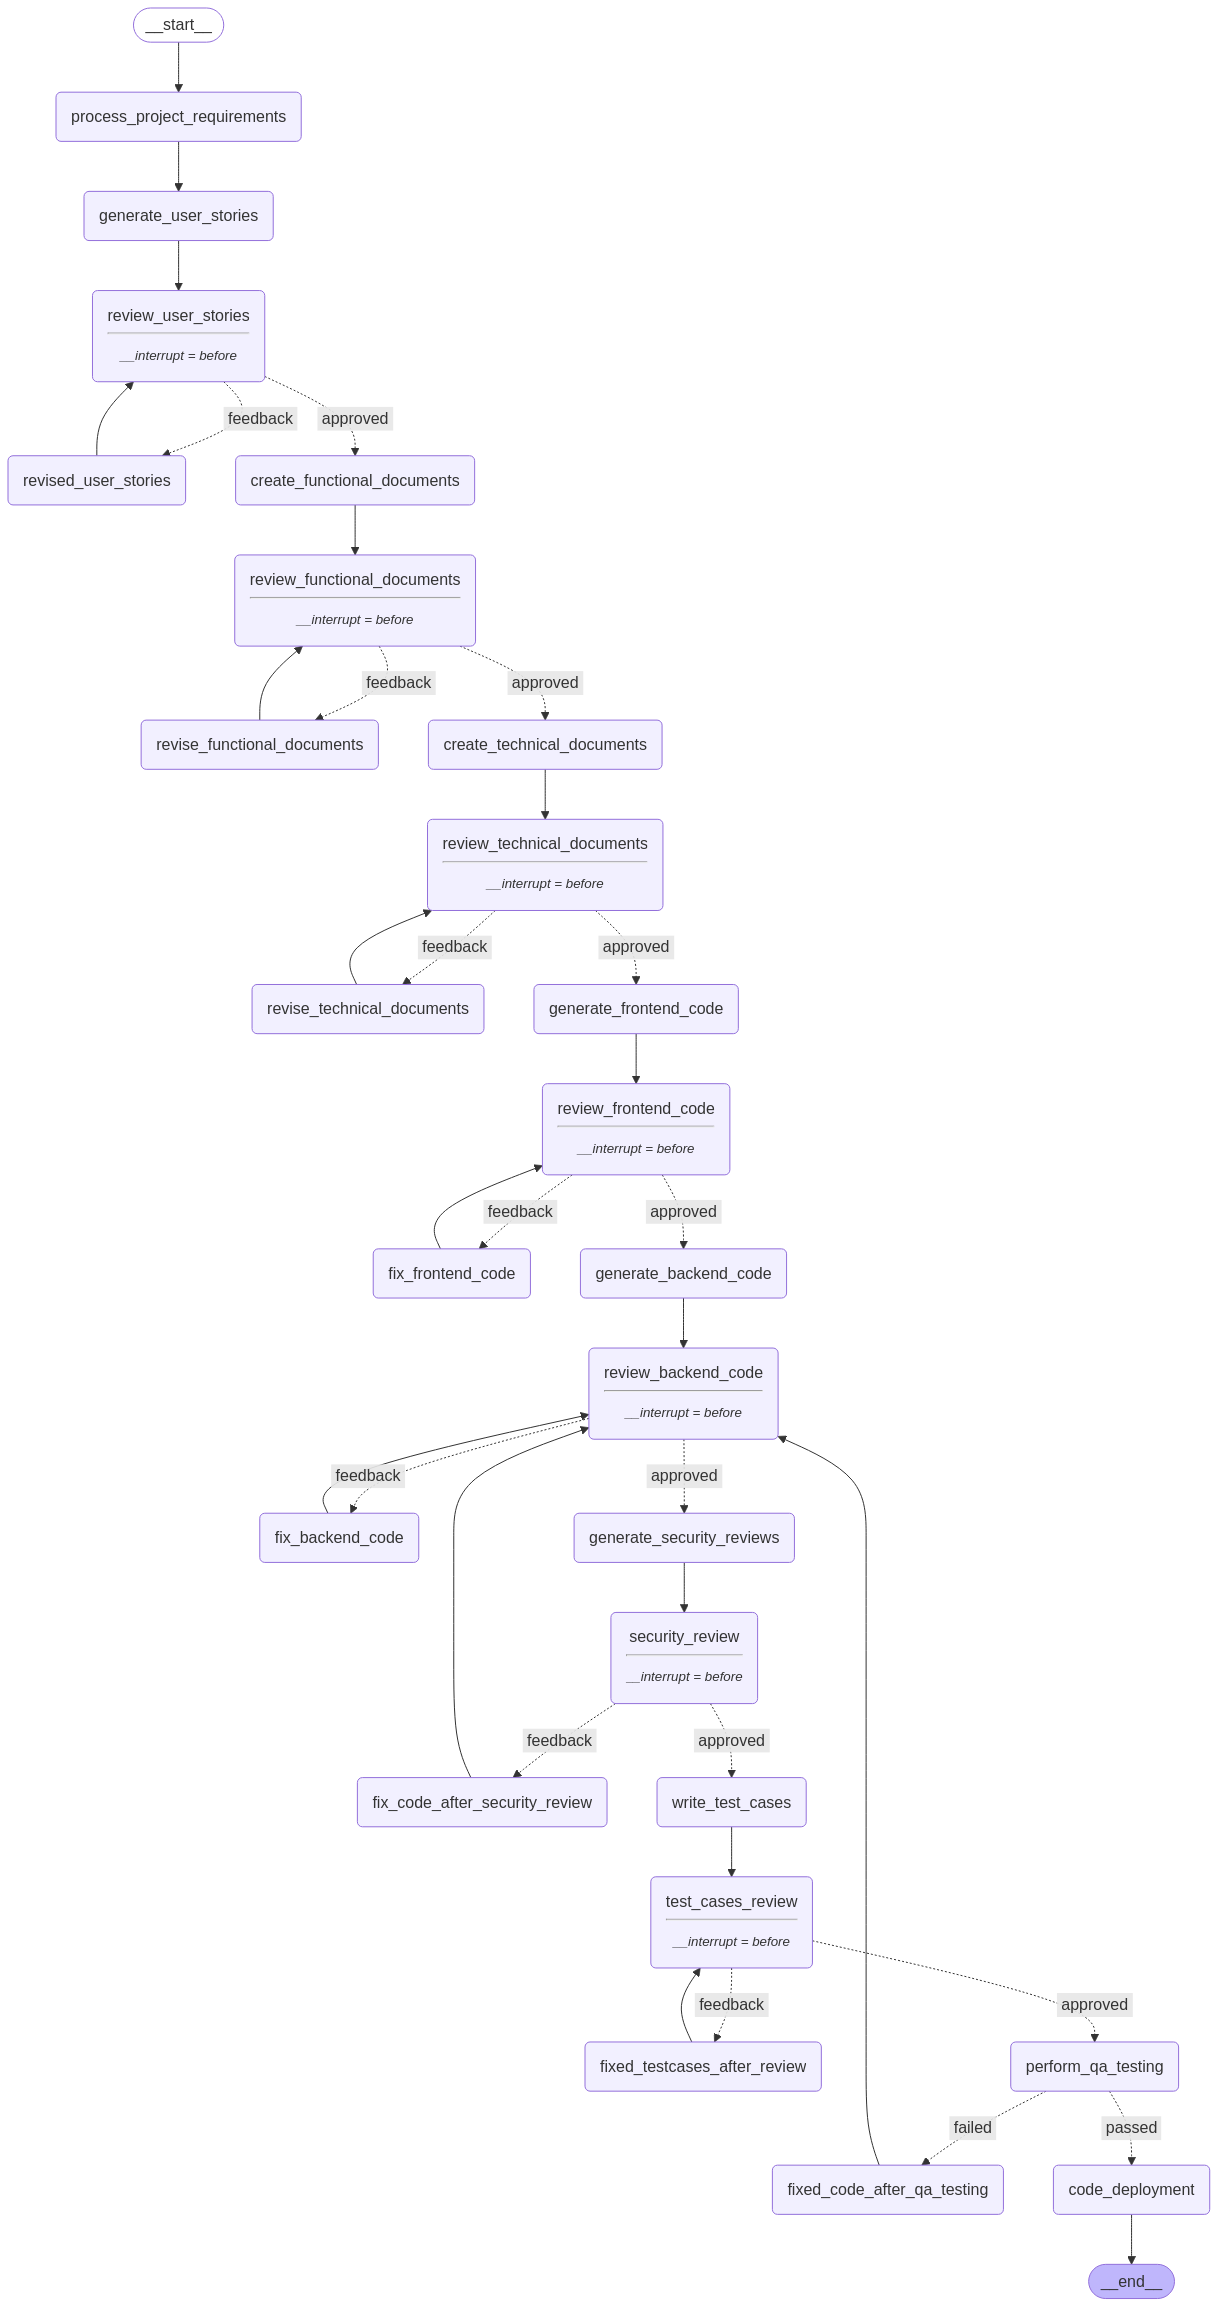

In [41]:
from IPython.display import Image, display
display(Image(sdlc_workflow.get_graph().draw_mermaid_png()))

In [42]:
# from IPython.display import Image, display
# display(Image(sdlc_workflow.get_graph().draw_mermaid_png()))

# png_data = sdlc_workflow.get_graph().draw_mermaid_png()

# # Save it to a file
# with open("sdlc_workflow.png", "wb") as f:
#     f.write(png_data)

# Running the Graph

## User stories

In [43]:
project_title = "PayMate: Your Ultimate Payment Companion"
project_description = "PayMate is a comprehensive payment application that allows users to perform seamless transactions using the Unified Payments Interface (UPI). Beyond basic payments, PayMate offers features such as quick loans, bill payments, and a user-friendly interface, making it a one-stop solution for all financial needs."
requirements = ["Implement multi-factor authentication, including biometrics (fingerprint and facial recognition) and MPIN, to secure user accounts.​", "Enable users to link multiple bank accounts and perform instant fund transfers using UPI.", "Provide users with access to instant micro-loans with minimal documentation.", "Allow users to pay utility bills such as electricity, water, gas, and broadband directly through the app."]
requirements_string = "\n".join(requirements)

In [44]:
project_requirements = ProjectRequirements(
    title = project_title,
    description = project_description,
    requirements = requirements
)

initial_story_state = {
    "project_requirements" : project_requirements,
    "user_stories": [],
    "user_story_messages": HumanMessage(content=f"{project_requirements}"),
    "user_story_status": "in_progress",
    "revised_count" : 0,
}

# Thread
thread = {"configurable": {"thread_id": "12345"}}

state = None
for event in sdlc_workflow.stream(initial_story_state, thread, stream_mode="values"):
    state = event

state

In process_project_requirements...
In generate_user_stories...


{'project_requirements': ProjectRequirements(title='PayMate: Your Ultimate Payment Companion', description='PayMate is a comprehensive payment application that allows users to perform seamless transactions using the Unified Payments Interface (UPI). Beyond basic payments, PayMate offers features such as quick loans, bill payments, and a user-friendly interface, making it a one-stop solution for all financial needs.', requirements=['Implement multi-factor authentication, including biometrics (fingerprint and facial recognition) and MPIN, to secure user accounts.\u200b', 'Enable users to link multiple bank accounts and perform instant fund transfers using UPI.', 'Provide users with access to instant micro-loans with minimal documentation.', 'Allow users to pay utility bills such as electricity, water, gas, and broadband directly through the app.']),
 'revised_count': 0,
 'user_stories': [{'story_id': 'US-001',
   'title': 'Secure Account Access with Multi-Factor Authentication',
   'desc

In [45]:
state['user_stories']

[{'story_id': 'US-001',
  'title': 'Secure Account Access with Multi-Factor Authentication',
  'description': 'As a user, I want to secure my account with multi-factor authentication, so that my financial information is protected.',
  'acceptance_criteria': ['User can enable biometric authentication (fingerprint or facial recognition).',
   'User can set up and use an MPIN for authentication.',
   'The application prompts for a second factor of authentication upon login.']},
 {'story_id': 'US-002',
  'title': 'Link Multiple Bank Accounts for UPI Transfers',
  'description': 'As a user, I want to link multiple bank accounts to my profile, so that I can easily transfer funds from different sources.',
  'acceptance_criteria': ['User can add multiple bank accounts to their profile.',
   'User can select a default bank account for UPI transactions.',
   'User can view a list of linked bank accounts.']},
 {'story_id': 'US-003',
  'title': 'Access Instant Micro-Loans',
  'description': 'As a 

In [45]:
current_state = sdlc_workflow.get_state(thread) 
current_state.next

('review_user_stories',)

In [46]:
user_feedback = "In above user stories, add a user story for buy insurance from the app and return all the user stories"
sdlc_workflow.update_state(thread, { "user_story_messages" : HumanMessage(content=f'{user_feedback}')})

for event in sdlc_workflow.stream(None, thread, stream_mode="values"):
    state = event

state

In review_user_stories...
user_review :  in above user stories, add a user story for buy insurance from the app and return all the user stories
In revised_user_stories...
revised_count :  1


{'project_requirements': ProjectRequirements(title='PayMate: Your Ultimate Payment Companion', description='PayMate is a comprehensive payment application that allows users to perform seamless transactions using the Unified Payments Interface (UPI). Beyond basic payments, PayMate offers features such as quick loans, bill payments, and a user-friendly interface, making it a one-stop solution for all financial needs.', requirements=['Implement multi-factor authentication, including biometrics (fingerprint and facial recognition) and MPIN, to secure user accounts.\u200b', 'Enable users to link multiple bank accounts and perform instant fund transfers using UPI.', 'Provide users with access to instant micro-loans with minimal documentation.', 'Allow users to pay utility bills such as electricity, water, gas, and broadband directly through the app.']),
 'revised_count': 1,
 'user_stories': [{'story_id': 'US-001',
   'title': 'Secure Account Access with Multi-Factor Authentication',
   'desc

In [47]:
user_feedback = "In above user stories, also add a user story to book the flight tickets and return all the user stories"
sdlc_workflow.update_state(thread, { "user_story_messages" : HumanMessage(content=f'{user_feedback}')})

for event in sdlc_workflow.stream(None, thread, stream_mode="values"):
    state = event

state

In review_user_stories...
user_review :  in above user stories, also add a user story to book the flight tickets and return all the user stories
In revised_user_stories...
revised_count :  2


{'project_requirements': ProjectRequirements(title='PayMate: Your Ultimate Payment Companion', description='PayMate is a comprehensive payment application that allows users to perform seamless transactions using the Unified Payments Interface (UPI). Beyond basic payments, PayMate offers features such as quick loans, bill payments, and a user-friendly interface, making it a one-stop solution for all financial needs.', requirements=['Implement multi-factor authentication, including biometrics (fingerprint and facial recognition) and MPIN, to secure user accounts.\u200b', 'Enable users to link multiple bank accounts and perform instant fund transfers using UPI.', 'Provide users with access to instant micro-loans with minimal documentation.', 'Allow users to pay utility bills such as electricity, water, gas, and broadband directly through the app.']),
 'revised_count': 2,
 'user_stories': [{'story_id': 'US-001',
   'title': 'Secure Account Access with Multi-Factor Authentication',
   'desc

In [ ]:
sdlc_workflow.update_state(thread, { "user_story_messages" : HumanMessage(content='Approved'), "revised_count" : 0})

for event in sdlc_workflow.stream(None, thread, stream_mode="values"):
    state = event

state

In review_user_stories...
user_review :  approved
In create_functional_documents...


{'project_requirements': ProjectRequirements(title='PayMate: Your Ultimate Payment Companion', description='PayMate is a comprehensive payment application that allows users to perform seamless transactions using the Unified Payments Interface (UPI). Beyond basic payments, PayMate offers features such as quick loans, bill payments, and a user-friendly interface, making it a one-stop solution for all financial needs.', requirements=['Implement multi-factor authentication, including biometrics (fingerprint and facial recognition) and MPIN, to secure user accounts.\u200b', 'Enable users to link multiple bank accounts and perform instant fund transfers using UPI.', 'Provide users with access to instant micro-loans with minimal documentation.', 'Allow users to pay utility bills such as electricity, water, gas, and broadband directly through the app.']),
 'revised_count': 0,
 'user_stories': [{'story_id': 'US-001',
   'title': 'Secure User Accounts with Multi-Factor Authentication',
   'descr

## Documentation

In [303]:
current_state = sdlc_workflow.get_state(thread) 
current_state.next

('review_functional_documents',)

In [304]:
user_feedback = "Revised the document to book the flight tickets from the bookMyTrip.com site."
sdlc_workflow.update_state(thread, { "functional_messages" : HumanMessage(content=f'{user_feedback}')})
# sdlc_workflow.update_state(thread, { "functional_messages" : HumanMessage(content='Approved'), "revised_count" : 0})

for event in sdlc_workflow.stream(None, thread, stream_mode="values"):
    state = event

state

In review_functional_documents...
user feedback: revised the document to book the flight tickets from the bookmytrip.com site.
In revise_functional_documents...
user feedback: revised the document to book the flight tickets from the bookmytrip.com site.
revised_count : 1


{'project_requirements': ProjectRequirements(title='PayMate: Your Ultimate Payment Companion', description='PayMate is a comprehensive payment application that allows users to perform seamless transactions using the Unified Payments Interface (UPI). Beyond basic payments, PayMate offers features such as quick loans, bill payments, and a user-friendly interface, making it a one-stop solution for all financial needs.', requirements=['Implement multi-factor authentication, including biometrics (fingerprint and facial recognition) and MPIN, to secure user accounts.\u200b', 'Enable users to link multiple bank accounts and perform instant fund transfers using UPI.', 'Provide users with access to instant micro-loans with minimal documentation.', 'Allow users to pay utility bills such as electricity, water, gas, and broadband directly through the app.']),
 'revised_count': 1,
 'user_stories': [{'story_id': 'US-001',
   'title': 'Secure User Accounts with Multi-Factor Authentication',
   'descr

In [305]:
sdlc_workflow.update_state(thread, { "functional_messages" : HumanMessage(content='Approved'), "revised_count" : 0})

for event in sdlc_workflow.stream(None, thread, stream_mode="values"):
    state = event

state

In review_functional_documents...
user feedback: approved
In create_technical_documents...


{'project_requirements': ProjectRequirements(title='PayMate: Your Ultimate Payment Companion', description='PayMate is a comprehensive payment application that allows users to perform seamless transactions using the Unified Payments Interface (UPI). Beyond basic payments, PayMate offers features such as quick loans, bill payments, and a user-friendly interface, making it a one-stop solution for all financial needs.', requirements=['Implement multi-factor authentication, including biometrics (fingerprint and facial recognition) and MPIN, to secure user accounts.\u200b', 'Enable users to link multiple bank accounts and perform instant fund transfers using UPI.', 'Provide users with access to instant micro-loans with minimal documentation.', 'Allow users to pay utility bills such as electricity, water, gas, and broadband directly through the app.']),
 'revised_count': 0,
 'user_stories': [{'story_id': 'US-001',
   'title': 'Secure User Accounts with Multi-Factor Authentication',
   'descr

In [306]:
## technical document
current_state = sdlc_workflow.get_state(thread) 
current_state.next

('review_technical_documents',)

In [ ]:
user_feedback = "Revised the technical document for book the flight tickets from the goibibo.com site."
sdlc_workflow.update_state(thread, { "technical_messages" : HumanMessage(content=f'{user_feedback}')})
# sdlc_workflow.update_state(thread, { "technical_messages" : HumanMessage(content='Approved'), "revised_count" : 0})

for event in sdlc_workflow.stream(None, thread, stream_mode="values"):
    state = event
    
state


In review_technical_documents...
user feedback: revised the technical document for book the flight tickets from the goibibo.com site.
In revise_technical_documents...
user feedback: revised the technical document for book the flight tickets from the goibibo.com site.
revised_count : 1


{'project_requirements': ProjectRequirements(title='PayMate: Your Ultimate Payment Companion', description='PayMate is a comprehensive payment application that allows users to perform seamless transactions using the Unified Payments Interface (UPI). Beyond basic payments, PayMate offers features such as quick loans, bill payments, and a user-friendly interface, making it a one-stop solution for all financial needs.', requirements=['Implement multi-factor authentication, including biometrics (fingerprint and facial recognition) and MPIN, to secure user accounts.\u200b', 'Enable users to link multiple bank accounts and perform instant fund transfers using UPI.', 'Provide users with access to instant micro-loans with minimal documentation.', 'Allow users to pay utility bills such as electricity, water, gas, and broadband directly through the app.']),
 'revised_count': 1,
 'user_stories': [{'story_id': 'US-001',
   'title': 'Secure User Accounts with Multi-Factor Authentication',
   'descr

In [308]:
sdlc_workflow.update_state(thread, { "technical_messages" : HumanMessage(content='Approved'), "revised_count" : 0})

for event in sdlc_workflow.stream(None, thread, stream_mode="values"):
    state = event
    
state


In review_technical_documents...
user feedback: approved
In generate_frontend_code...


{'project_requirements': ProjectRequirements(title='PayMate: Your Ultimate Payment Companion', description='PayMate is a comprehensive payment application that allows users to perform seamless transactions using the Unified Payments Interface (UPI). Beyond basic payments, PayMate offers features such as quick loans, bill payments, and a user-friendly interface, making it a one-stop solution for all financial needs.', requirements=['Implement multi-factor authentication, including biometrics (fingerprint and facial recognition) and MPIN, to secure user accounts.\u200b', 'Enable users to link multiple bank accounts and perform instant fund transfers using UPI.', 'Provide users with access to instant micro-loans with minimal documentation.', 'Allow users to pay utility bills such as electricity, water, gas, and broadband directly through the app.']),
 'revised_count': 0,
 'user_stories': [{'story_id': 'US-001',
   'title': 'Secure User Accounts with Multi-Factor Authentication',
   'descr

### Frontend Code

In [309]:
## technical document
current_state = sdlc_workflow.get_state(thread) 
current_state.next

('review_frontend_code',)

In [ ]:
user_feedback = "Revised the frontend code for buy insurance from the app"
sdlc_workflow.update_state(thread, { "frontend_messages" : HumanMessage(content=f'{user_feedback}')})
# sdlc_workflow.update_state(thread, { "frontend_messages" : HumanMessage(content='Approved'), "revised_count" : 0})

for event in sdlc_workflow.stream(None, thread, stream_mode="values"):
    state = event
    
state


In review_frontend_code
user feedback: revised the frontend code for buy insurance from the app
In fix_frontend_code...
revised_count : 1


{'project_requirements': ProjectRequirements(title='PayMate: Your Ultimate Payment Companion', description='PayMate is a comprehensive payment application that allows users to perform seamless transactions using the Unified Payments Interface (UPI). Beyond basic payments, PayMate offers features such as quick loans, bill payments, and a user-friendly interface, making it a one-stop solution for all financial needs.', requirements=['Implement multi-factor authentication, including biometrics (fingerprint and facial recognition) and MPIN, to secure user accounts.\u200b', 'Enable users to link multiple bank accounts and perform instant fund transfers using UPI.', 'Provide users with access to instant micro-loans with minimal documentation.', 'Allow users to pay utility bills such as electricity, water, gas, and broadband directly through the app.']),
 'revised_count': 1,
 'user_stories': [{'story_id': 'US-001',
   'title': 'Secure User Accounts with Multi-Factor Authentication',
   'descr

In [311]:
user_feedback = "Revised the frontend code for buy insurance from the app"
# sdlc_workflow.update_state(thread, { "frontend_messages" : HumanMessage(content=f'{user_feedback}')})
sdlc_workflow.update_state(thread, { "frontend_messages" : HumanMessage(content='Approved'),  "revised_count" : 0})

for event in sdlc_workflow.stream(None, thread, stream_mode="values"):
    state = event
    
state


In review_frontend_code
user feedback: approved
In generate_backend_code...


{'project_requirements': ProjectRequirements(title='PayMate: Your Ultimate Payment Companion', description='PayMate is a comprehensive payment application that allows users to perform seamless transactions using the Unified Payments Interface (UPI). Beyond basic payments, PayMate offers features such as quick loans, bill payments, and a user-friendly interface, making it a one-stop solution for all financial needs.', requirements=['Implement multi-factor authentication, including biometrics (fingerprint and facial recognition) and MPIN, to secure user accounts.\u200b', 'Enable users to link multiple bank accounts and perform instant fund transfers using UPI.', 'Provide users with access to instant micro-loans with minimal documentation.', 'Allow users to pay utility bills such as electricity, water, gas, and broadband directly through the app.']),
 'revised_count': 0,
 'user_stories': [{'story_id': 'US-001',
   'title': 'Secure User Accounts with Multi-Factor Authentication',
   'descr

### Backend code

In [312]:
## technical document
current_state = sdlc_workflow.get_state(thread) 
current_state.next

('review_backend_code',)

In [ ]:
user_feedback = "Revised the backend code for buy insurance from the app"
sdlc_workflow.update_state(thread, { "backend_messages" : HumanMessage(content=f'{user_feedback}')})
# sdlc_workflow.update_state(thread, { "backend_messages" : HumanMessage(content='Approved'), "revised_count" : 0})

for event in sdlc_workflow.stream(None, thread, stream_mode="values"):
    state = event
    
state

In review_backend_code
user feedback: revised the backend code for buy insurance from the app
In fix_backend_code...
revised_count : 1


{'project_requirements': ProjectRequirements(title='PayMate: Your Ultimate Payment Companion', description='PayMate is a comprehensive payment application that allows users to perform seamless transactions using the Unified Payments Interface (UPI). Beyond basic payments, PayMate offers features such as quick loans, bill payments, and a user-friendly interface, making it a one-stop solution for all financial needs.', requirements=['Implement multi-factor authentication, including biometrics (fingerprint and facial recognition) and MPIN, to secure user accounts.\u200b', 'Enable users to link multiple bank accounts and perform instant fund transfers using UPI.', 'Provide users with access to instant micro-loans with minimal documentation.', 'Allow users to pay utility bills such as electricity, water, gas, and broadband directly through the app.']),
 'revised_count': 1,
 'user_stories': [{'story_id': 'US-001',
   'title': 'Secure User Accounts with Multi-Factor Authentication',
   'descr

In [ ]:
user_feedback = "Revised the backend code for buy insurance from the app"
# sdlc_workflow.update_state(thread, { "backend_messages" : HumanMessage(content=f'{user_feedback}')})
sdlc_workflow.update_state(thread, { "backend_messages" : HumanMessage(content='Approved'), "revised_count" : 0})

for event in sdlc_workflow.stream(None, thread, stream_mode="values"):
    state = event
    
state


In review_backend_code
user feedback: approved
In generate_security_reviews...


OutputParserException: Invalid json output: Based on the provided codebase, I'll conduct a security review and return the findings in the requested JSON format. Here are the identified security issues, ordered by priority:

```json
[
  {
    "sec_id": "SR-001",
    "review": "The JWT_SECRET is hardcoded in the middleware/auth.js file. If this secret is compromised, attackers can forge tokens and impersonate users.",
    "file_path": "src/middleware/auth.js",
    "recommendation": "Move the JWT_SECRET to an environment variable and ensure that it is stored securely.",
    "priority": "high"
  },
  {
    "sec_id": "SR-002",
    "review": "SQL queries in the products.js and orders.js files directly use user input without parameterization, which could potentially lead to SQL injection vulnerabilities if the input is not properly sanitized.",
    "file_path": "src/routes/products.js",
    "recommendation": "Use parameterized queries or prepared statements to prevent SQL injection.",
    "priority": "high"
  },
  {
    "sec_id": "SR-003",
    "review": "The middleware/auth.js file uses a static expiration time (24 hours) for JWT tokens. Depending on the use case, a shorter expiration time might be more secure.",
    "file_path": "src/middleware/auth.js",
    "recommendation": "Consider reducing the token expiration time and implementing token refreshing mechanisms.",
    "priority": "medium"
  },
  {
    "sec_id": "SR-004",
    "review": "The error messages returned to the client in the auth.js and products.js files are not specific and could potentially leak sensitive information about the backend logic.",
    "file_path": "src/routes/auth.js",
    "recommendation": "Return generic error messages to avoid revealing backend details.",
    "priority": "medium"
  },
  {
    "sec_id": "SR-005",
    "review": "The password hashing in the auth.js file uses bcryptjs with a hardcoded salt round factor of 10. Without validation, this could be insecure if the salt rounds are too low.",
    "file_path": "src/routes/auth.js",
    "recommendation": "Consider dynamically setting the salt rounds based on system performance to ensure a secure and efficient hashing process.",
    "priority": "low"
  },
  {
    "sec_id": "SR-006",
    "review": "The middleware/auth.js file's `authenticateToken` function returns a generic "Invalid token" message when the token is invalid. This could potentially be exploited by an attacker to validate usernames.",
    "file_path": "src/middleware/auth.js",
    "recommendation": "Return a generic "Authentication required" message for all authentication failures.",
    "priority": "low"
  }
]
```

This JSON array contains a detailed analysis of each security issue found within the codebase, including recommendations for remediation. Each issue is categorized based on its severity and likelihood of exploitation.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSING_FAILURE 

## Security Review

In [252]:
## technical document
current_state = sdlc_workflow.get_state(thread) 
current_state.next

('security_review',)

In [253]:
user_feedback = "Revised the security review for buy insurance from the app"
# sdlc_workflow.update_state(thread, { "security_reviews_messages" : HumanMessage(content=f'{user_feedback}')})
sdlc_workflow.update_state(thread, { "security_reviews_messages" : HumanMessage(content='Approved'), "revised_count" : 0})

for event in sdlc_workflow.stream(None, thread, stream_mode="values"):
    state = event
    
state


In security_review...
user feedback: approved
In write_test_cases...


/Users/ideyalabs/Desktop/new/sdlc-copilot/venv/lib/python3.12/site-packages/pydantic/main.py:453: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [input_value=['src/routes/products.js'... 'src/routes/orders.js'], input_type=list])
  return self.__pydantic_serializer__.to_python(
/Users/ideyalabs/Desktop/new/sdlc-copilot/venv/lib/python3.12/site-packages/pydantic/main.py:453: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [input_value=['src/routes/products.js'... 'src/routes/orders.js'], input_type=list])
  return self.__pydantic_serializer__.to_python(
/Users/ideyalabs/Desktop/new/sdlc-copilot/venv/lib/python3.12/site-packages/pydantic/main.py:453: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [input_value=['src/ro

{'project_requirements': ProjectRequirements(title='PayMate: Your Ultimate Payment Companion', description='PayMate is a comprehensive payment application that allows users to perform seamless transactions using the Unified Payments Interface (UPI). Beyond basic payments, PayMate offers features such as quick loans, bill payments, and a user-friendly interface, making it a one-stop solution for all financial needs.', requirements=['Implement multi-factor authentication, including biometrics (fingerprint and facial recognition) and MPIN, to secure user accounts.\u200b', 'Enable users to link multiple bank accounts and perform instant fund transfers using UPI.', 'Provide users with access to instant micro-loans with minimal documentation.', 'Allow users to pay utility bills such as electricity, water, gas, and broadband directly through the app.']),
 'revised_count': 0,
 'user_stories': [{'story_id': 'US-001',
   'title': 'Secure User Accounts with Multi-Factor Authentication',
   'descr

In [ ]:
pr("Completed till here")

NameError: name 'pr' is not defined

## Test Cases

In [45]:
## technical document
current_state = sdlc_workflow.get_state(thread) 
current_state.next

('test_cases_review',)

In [46]:
user_feedback = "Revised the test cases for buy insurance from the app"
sdlc_workflow.update_state(thread, { "test_cases_messages" : HumanMessage(content=f'{user_feedback}')})
# sdlc_workflow.update_state(thread, { "test_cases_messages" : HumanMessage(content='Approved'), "revised_count" : 0})

for event in sdlc_workflow.stream(None, thread, stream_mode="values"):
    state = event
    
state


In test_cases_review...
user feedback: revised the test cases for buy insurance from the app
In fixed_testcases_after_review...
revised_count : 1


{'project_requirements': ProjectRequirements(title='PayMate: Your Ultimate Payment Companion', description='PayMate is a comprehensive payment application that allows users to perform seamless transactions using the Unified Payments Interface (UPI). Beyond basic payments, PayMate offers features such as quick loans, bill payments, and a user-friendly interface, making it a one-stop solution for all financial needs.', requirements=['Implement multi-factor authentication, including biometrics (fingerprint and facial recognition) and MPIN, to secure user accounts.\u200b', 'Enable users to link multiple bank accounts and perform instant fund transfers using UPI.', 'Provide users with access to instant micro-loans with minimal documentation.', 'Allow users to pay utility bills such as electricity, water, gas, and broadband directly through the app.']),
 'revised_count': 1,
 'user_stories': [{'story_id': 'US-001',
   'title': 'Secure Account with Multi-Factor Authentication',
   'description

In [47]:
## technical document
current_state = sdlc_workflow.get_state(thread) 
current_state.next

('test_cases_review',)

In [48]:
user_feedback = "Revised the test cases for buy insurance from the app"
# sdlc_workflow.update_state(thread, { "test_cases_messages" : HumanMessage(content=f'{user_feedback}')})
sdlc_workflow.update_state(thread, { "test_cases_messages" : HumanMessage(content='Approved'), "revised_count" : 0})

for event in sdlc_workflow.stream(None, thread, stream_mode="values"):
    state = event
    
state


In test_cases_review...
user feedback: approved
In perform_qa_testing...
In code_deployment...


{'project_requirements': ProjectRequirements(title='PayMate: Your Ultimate Payment Companion', description='PayMate is a comprehensive payment application that allows users to perform seamless transactions using the Unified Payments Interface (UPI). Beyond basic payments, PayMate offers features such as quick loans, bill payments, and a user-friendly interface, making it a one-stop solution for all financial needs.', requirements=['Implement multi-factor authentication, including biometrics (fingerprint and facial recognition) and MPIN, to secure user accounts.\u200b', 'Enable users to link multiple bank accounts and perform instant fund transfers using UPI.', 'Provide users with access to instant micro-loans with minimal documentation.', 'Allow users to pay utility bills such as electricity, water, gas, and broadband directly through the app.']),
 'revised_count': 0,
 'user_stories': [{'story_id': 'US-001',
   'title': 'Secure Account with Multi-Factor Authentication',
   'description

In [49]:
## technical document
current_state = sdlc_workflow.get_state(thread) 
current_state.next

()

## QA testing

In [50]:
## technical document
current_state = sdlc_workflow.get_state(thread) 
current_state.next

()

In [51]:
## technical document
current_state = sdlc_workflow.get_state(thread) 
current_state.next

()